In [1]:
import sys
sys.path.append("..")

In [2]:
import os

# prevent JAX from preallocating all GPU memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# data loading
import pandas as pd
import numpy as np

# plotting
#import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# pyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from numpyro.handlers import condition, trace
from numpyro.contrib.control_flow import scan, cond

numpyro.set_host_device_count(4)

# jax
import jax
import jax.numpy as jnp
import jax.random as random

if any([d.platform == "gpu" for d in jax.devices()]):
    numpyro.set_platform("gpu")

from jax.lib import xla_bridge
print(f"current XLA device: {xla_bridge.get_backend().platform}")

import weathergen as wx
import wxsbi

/opt/miniconda3/envs/wxsbi/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/3m/5yx1mwc969n3ddb__zkqyzdr0000gn/T/ipykernel_42960/3221953179.py:33: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated and will be removed in JAX v0.8.0; use jax.extend.backend.get_backend.
  print(f"current XLA device: {xla_bridge.get_backend().platform}")


current XLA device: cpu


In [3]:
numpyro.__version__

'0.19.0'

In [4]:
# enable autoreload of source files
%load_ext autoreload
%autoreload 2

# Data

In [5]:
import weathergen.data

name_map = weathergen.data.data_var_name_map(prec="pr", Tair_mean="tavg", Tair_min="tmin", Tair_max="tmax", time = "date")
basin_data_all = wx.data.load_time_series_csv("../data/potsdam.csv", name_map)

# Choose training period
basin_data_train = basin_data_all["1950":"1999"]

# Remove two datapoints where Tmin == Tavg
basin_data_train = basin_data_train.drop(index=basin_data_train.iloc[[6579, 6994], :].index)

In [6]:
assert np.all(basin_data_train["Tair_min"] < basin_data_train["Tair_mean"])
assert np.all(basin_data_train["Tair_min"] < basin_data_train["Tair_max"])
assert np.all(basin_data_train["Tair_mean"] < basin_data_train["Tair_max"])
assert np.all(basin_data_train["prec"] >= 0)

# Model

In [7]:
from weathergen.wgen.wgen_gamlss import *

In [8]:
#wgen = wx.WGEN(basin_data_train, model = wx.wgen_glm_v2, order = 2, Tair_freqs=Tair_freqs, prec_freqs=prec_freqs)
#wgen = wx.WGEN(basin_data_train, order = 2, Tair_freqs=Tair_freqs, prec_freqs=prec_freqs)
wgen = wx.WGEN(basin_data_train, model = WGEN_GAMLSS(), order = 2, Tair_freqs=[1/365.25, 2/365.25], prec_freqs=[1/365.25, 2/365.25])

Run variational inference for parameter estimates:

In [9]:
from numpyro.infer import SVI, TraceGraph_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoMultivariateNormal

num_iter = 50_000
prng = random.PRNGKey(1234)
guide = AutoMultivariateNormal(wgen.step, init_loc_fn=numpyro.infer.init_to_median)
#guide = AutoNormal(wgen.step, init_loc_fn=numpyro.infer.init_to_median)

svi_result = wgen.fit(num_iter, guide, subsample_time=1000, rng=prng)


100%|██████████| 50000/50000 [02:13<00:00, 374.35it/s, init loss: 5645551.0000, avg. loss [47501-50000]: 44090.8984]


Get posterior samples:

In [10]:
posterior_sampler = Predictive(guide, params=svi_result.params, num_samples=1000)
posterior_params = posterior_sampler(prng)
{k: v.mean(axis=0) for k,v in posterior_params.items() if k != "_auto_latent"}

{'Tavg_loc_lag': Array([-0.15098186,  0.9154675 ], dtype=float32),
 'Tavg_loc_pred': Array([2.3616042], dtype=float32),
 'Tavg_loc_scale_pred': Array([0.80087537], dtype=float32),
 'Tavg_loc_scale_seasonal': Array([ 0.07428356, -0.04605038,  0.04438144,  0.08381401], dtype=float32),
 'Tavg_loc_seasonal': Array([-0.6854128 ,  0.11613765, -2.6540406 ,  0.165303  ], dtype=float32),
 'Tavg_loc_seasonal_lag_interaction': Array([-0.01028233,  0.02909702, -0.00892446,  0.00188407,  0.03919052,
        -0.01694394,  0.0586645 , -0.00310721], dtype=float32),
 'Trange_disp_lag': Array([0.01055305, 0.10053603], dtype=float32),
 'Trange_disp_lag_seasonal_interaction': Array([-0.03414826, -0.03636864,  0.11172798, -0.0334093 , -0.02876415,
         0.03916081, -0.01836134, -0.02075182], dtype=float32),
 'Trange_disp_pred': Array([-0.25639176], dtype=float32),
 'Trange_disp_seasonal': Array([ 0.05164431, -0.01122258,  0.05269795, -0.22125816], dtype=float32),
 'Trange_mean_Tavg': Array([0.6138276], 

Get predictive distributions and run simulations

In [11]:
svi_predictive = Predictive(wgen.simulate, posterior_samples=posterior_params, parallel=True)
svi_preds = svi_predictive(prng)

In [9]:
obs = wgen.obs

In [10]:
from weathergen.plotting import *

In [11]:
obs["Tmin"] = obs["Tavg"] - obs["Trange"] * obs["Tskew"]
obs["Tmax"] = obs["Tmin"] + obs["Trange"]

## Model diagnostics

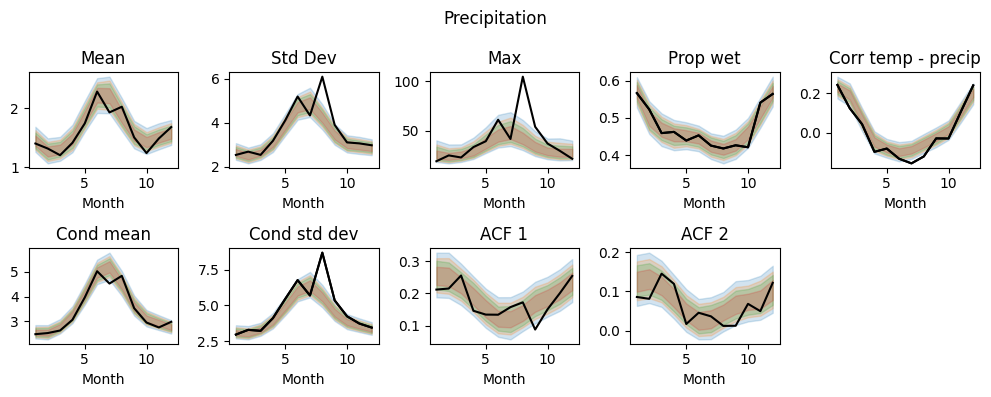

In [ ]:
fig = plt.figure(layout="tight", figsize=(10, 4))
fig.suptitle("Precipitation")

gs = GridSpec(2, 5, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(5)]
get_mean_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[1])
get_max_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[2])
get_prop_wet_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[3])
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[4])



# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(5)]
get_cond_mean_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[0])
get_cond_std_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[1])
get_acf_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[2], lag=1)
get_acf_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[3], lag=2)
ax_row_2[4].axis("off")

plt.savefig("plots/pr_paper.png", dpi = 300)

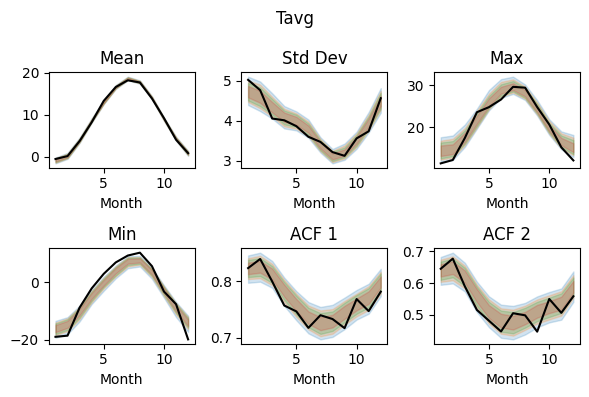

In [ ]:
fig = plt.figure(layout="tight", figsize=(6, 4))
fig.suptitle("Tavg")

gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_1[1])
get_max_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_1[2])

# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_min_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_2[0])
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_2[1], lag=1)
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_2[2], lag=2)

plt.savefig("plots/tavg_paper.png", dpi = 300)

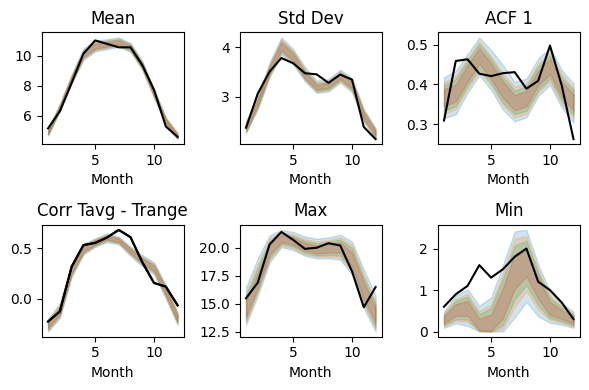

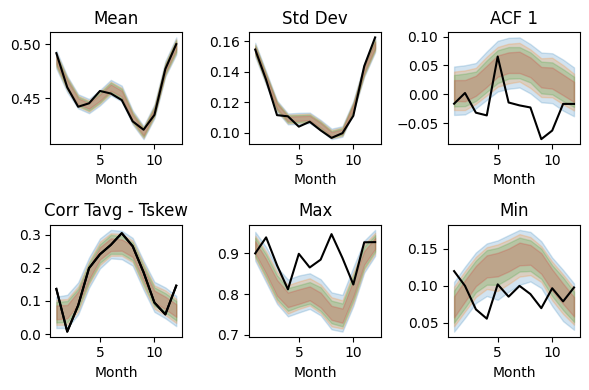

In [ ]:
fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Trange")

gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_1[1])
get_acf_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_1[2], lag=1)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Trange"], svi_preds["Trange"], basin_data_train.index,  "Tavg", "Trange", ax=ax_row_2[0])
#get_acf_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_2[1])
get_min_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_2[2])

plt.savefig("plots/trange_paper.png", dpi = 300)


fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Tskew")
gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_1[1])
get_acf_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_1[2], lag=1)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, "Tavg", "Tskew", ax=ax_row_2[0])
#get_acf_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_2[1])
get_min_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_2[2])

plt.savefig("plots/tskew_paper.png", dpi = 300)

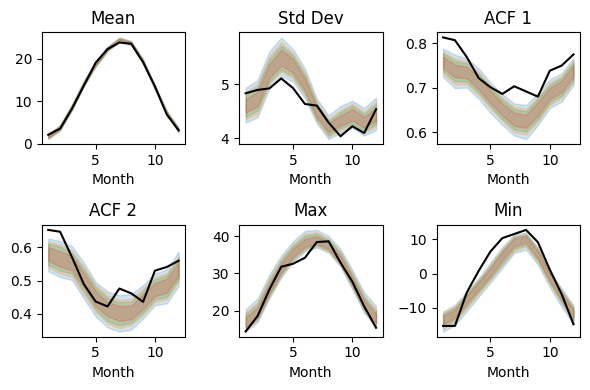

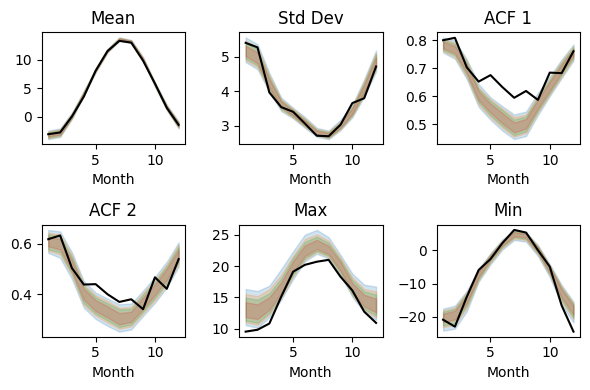

In [ ]:
fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Tmax")

gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_1[1])
get_acf_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_1[2], lag=1)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_acf_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_2[1])
get_min_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_2[2])

plt.savefig("plots/tmax_paper.png", dpi = 300)


fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Tmin")
gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_1[1])
get_acf_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_1[2], lag=1)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_acf_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_2[1])
get_min_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_2[2])

plt.savefig("plots/tmin_paper.png", dpi = 300)

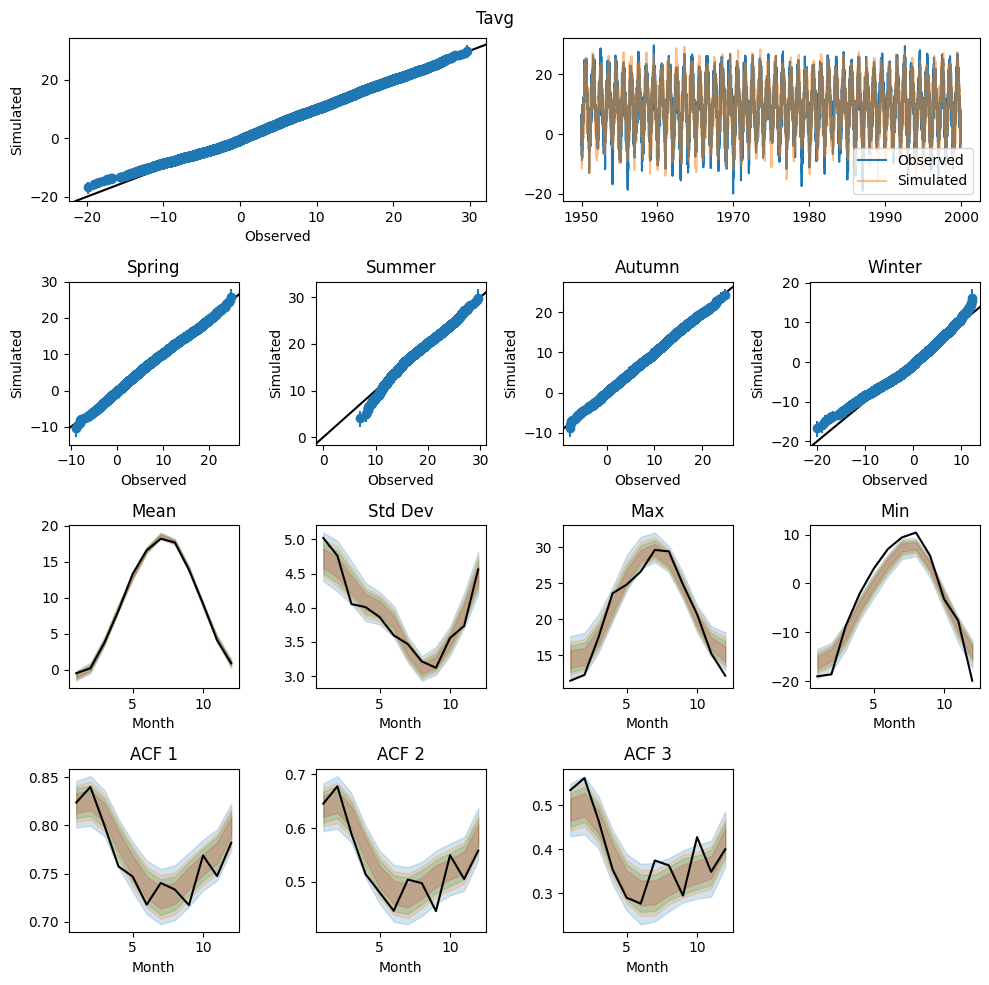

In [ ]:
Tavg_overview(obs, svi_preds, basin_data_train)
plt.savefig("plots/wgen_Tavg.png")

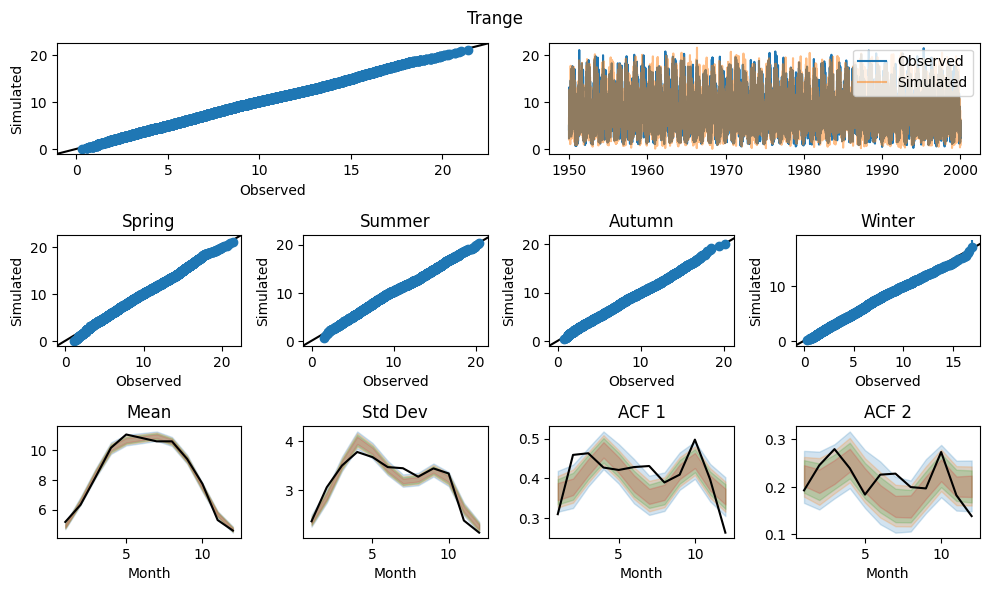

In [ ]:
Trange_overview(obs, svi_preds, basin_data_train)
plt.savefig("plots/wgen_Trange.png")

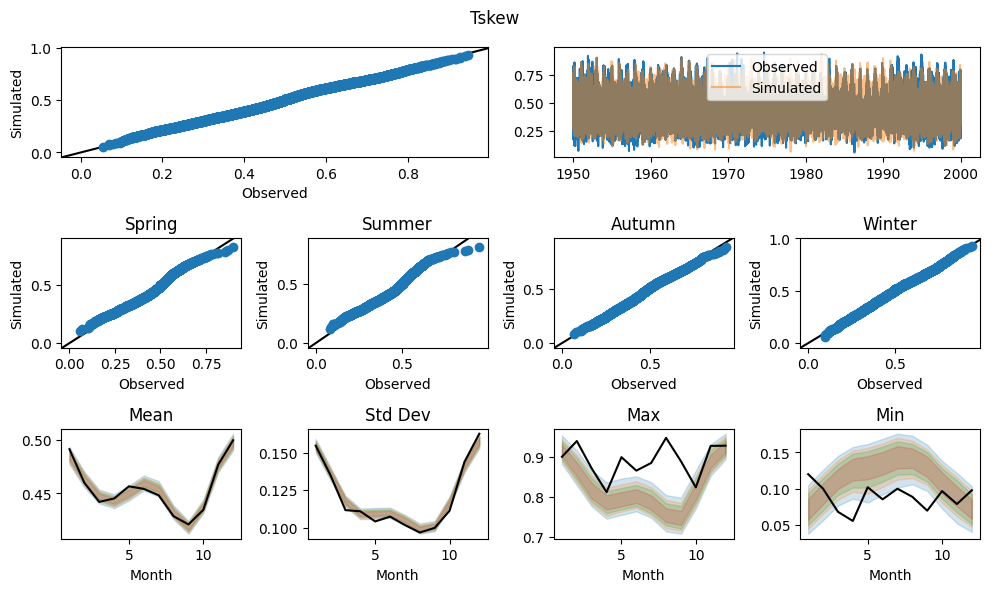

In [ ]:
Tskew_overview(obs, svi_preds, basin_data_train)
plt.savefig("plots/wgen_Tskew.png")

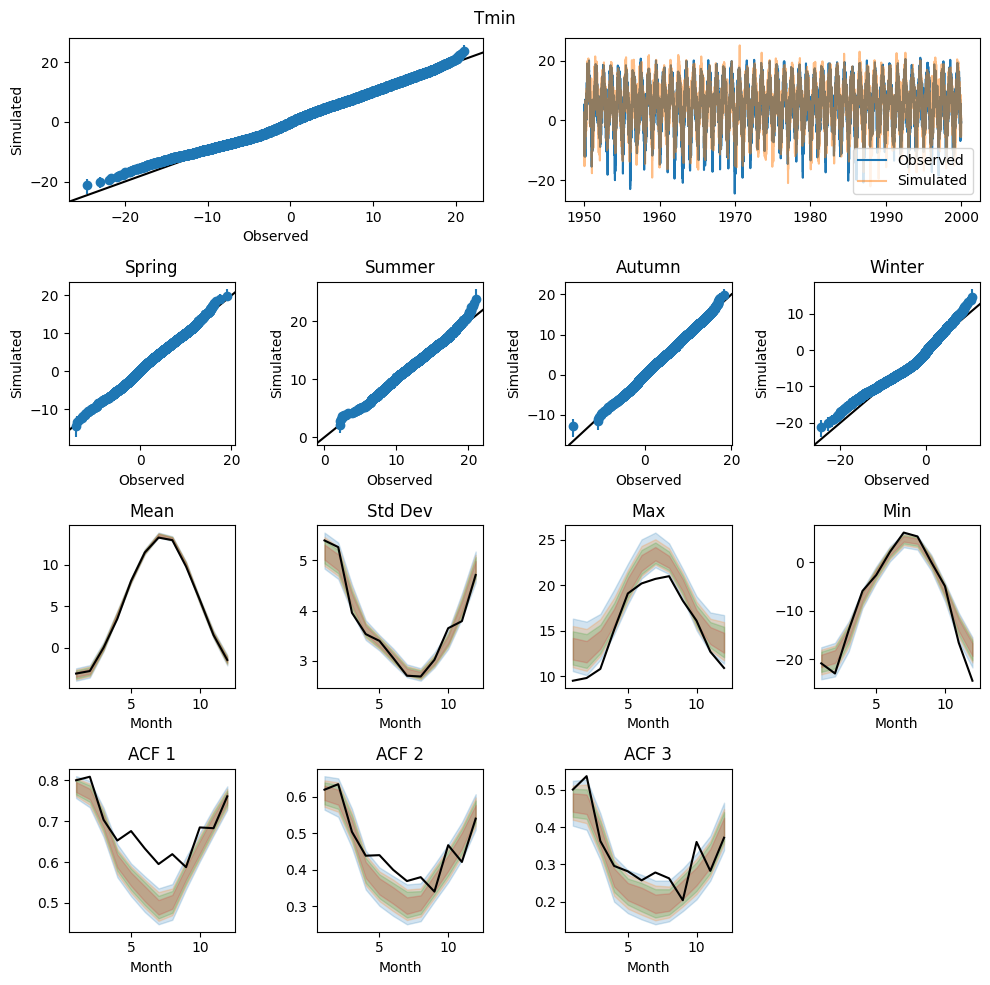

In [ ]:
Tmin_overview(obs, svi_preds, basin_data_train)
plt.savefig("plots/wgen_Tmin.png")

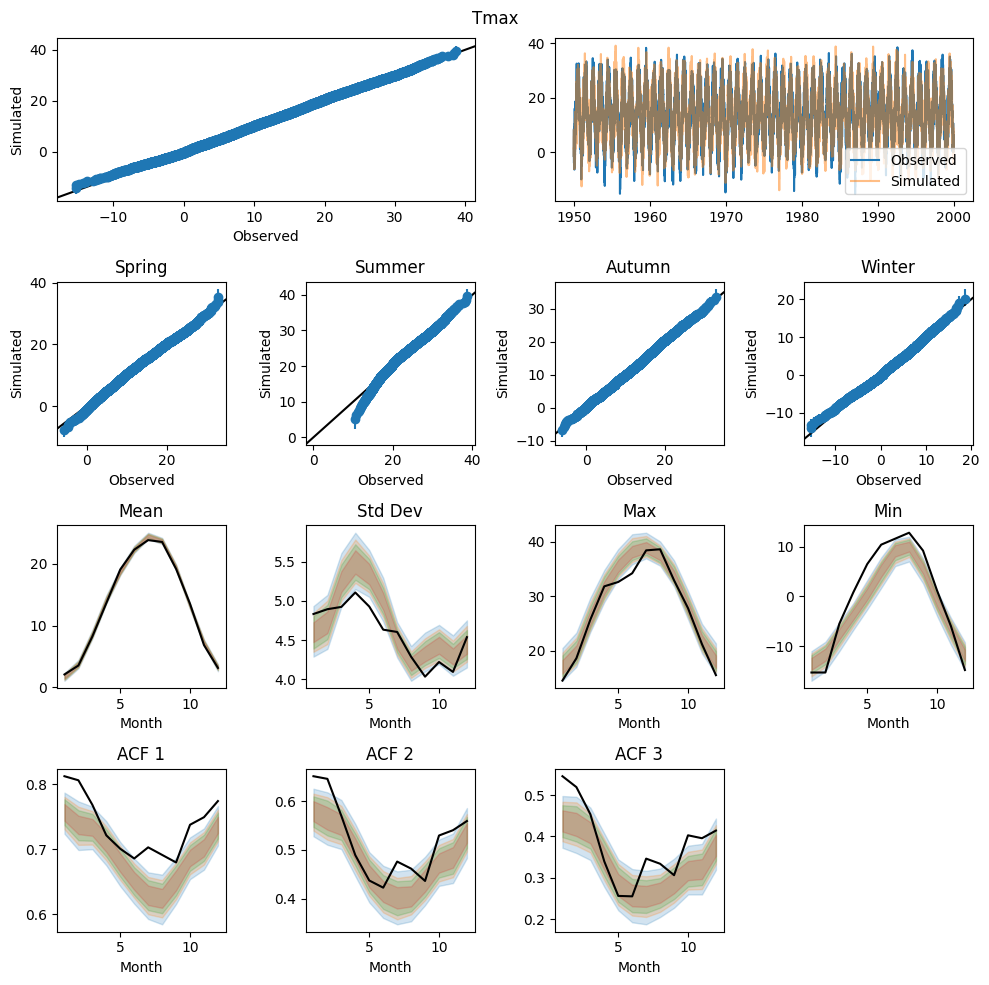

In [ ]:
Tmax_overview(obs, svi_preds, basin_data_train)
plt.savefig("plots/wgen_Tmax.png")

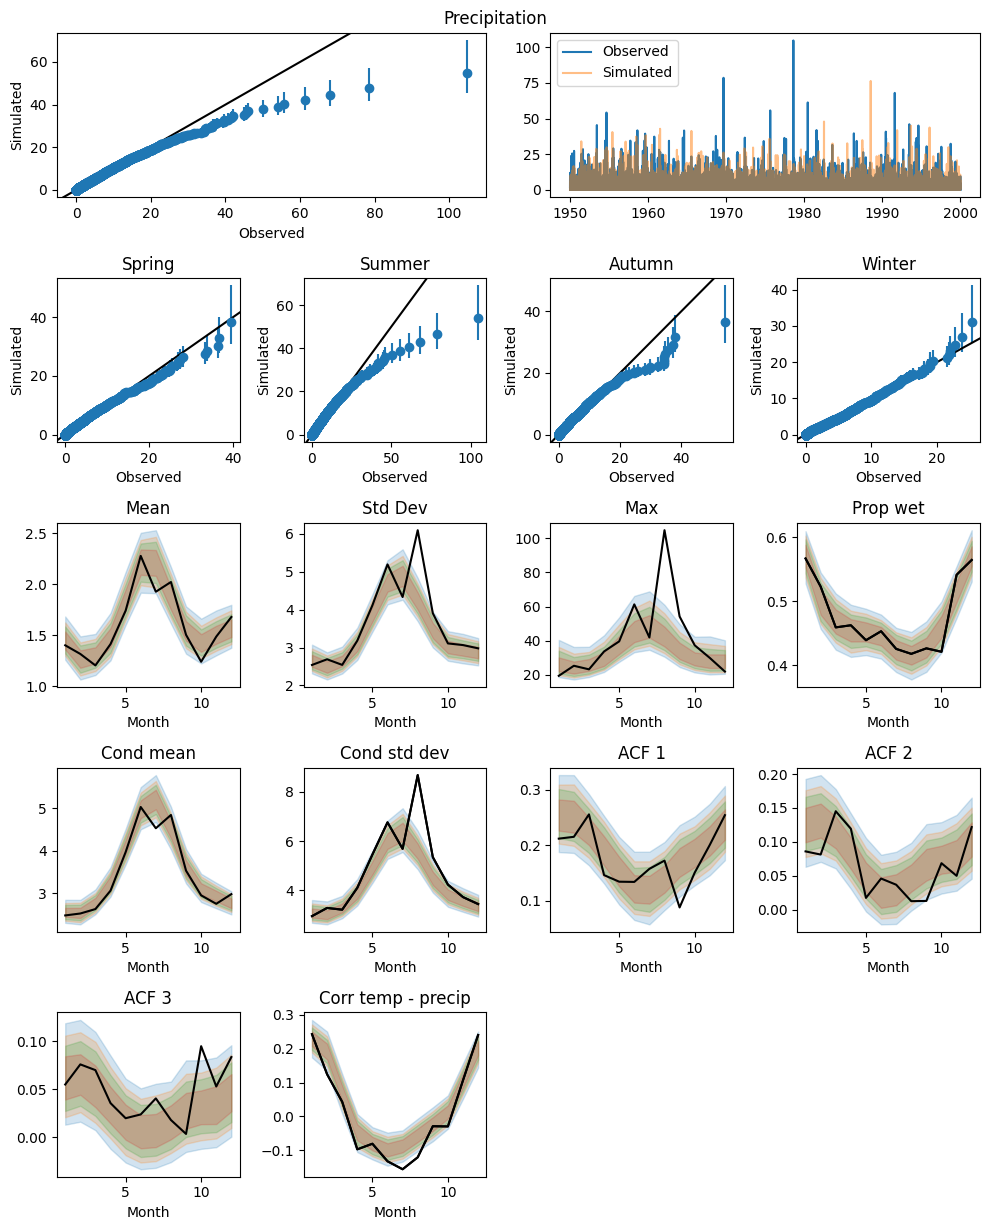

In [ ]:
prec_overview(obs, svi_preds, basin_data_train)
plt.savefig("plots/wgen_prec.png")

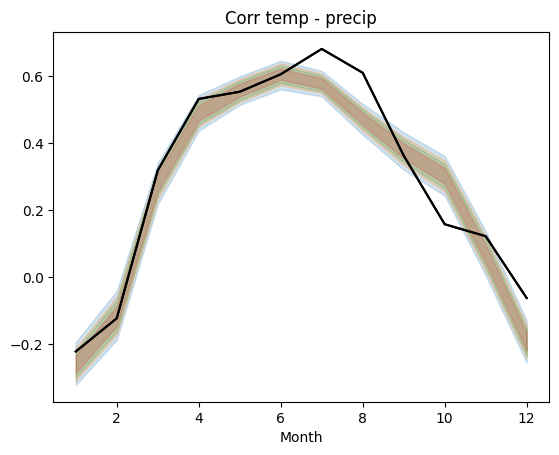

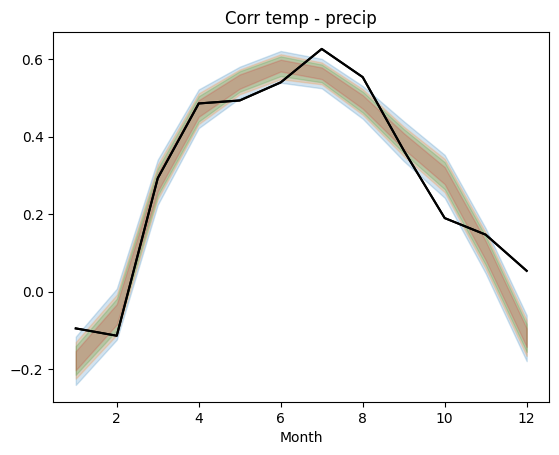

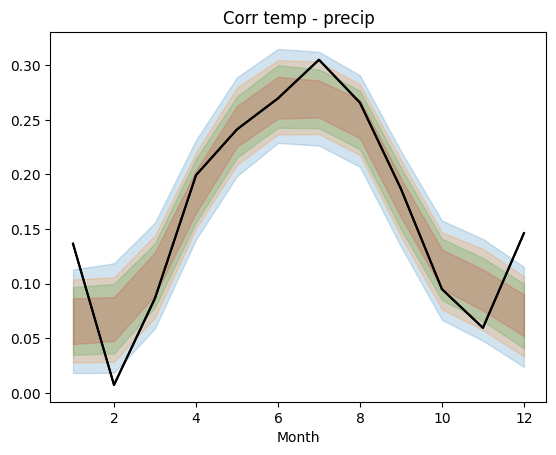

In [ ]:
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Trange"], svi_preds["Trange"], basin_data_train.index)

get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Trange"]*obs["Tskew"], svi_preds["Trange"]*svi_preds["Tskew"], basin_data_train.index)

get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["Tskew"], svi_preds["Tskew"], basin_data_train.index)

# SBI

In [15]:
import torch
torch.manual_seed(1234)

In [16]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Case study 1a (Tavg, pr, dry days const.):

Trend in tavg, precip, dry days constant:

In [17]:
num_rounds = 5

In [18]:
@wxsbi.summarystats("pmean", "pavgwet", "Tavgmean")
def case_study_1a(prec, Tavg, **kwargs):
    pmean = jnp.mean(prec, axis = -1)
    pavgwet = jnp.mean(prec > 0, axis = -1)
    Tavgmean = jnp.mean(Tavg, axis = -1)
    return jnp.stack([pmean, pavgwet, Tavgmean], axis = -1)

In [19]:
obs_stats = case_study_1a(**obs).flatten()
obs_stats

Array([1.6045674, 0.4748631, 8.816441 ], dtype=float32)

In [20]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.2)
obs_stats_target = obs_stats_target.at[2].add(3.5)
obs_stats_target

Array([ 1.925481 ,  0.4748631, 12.316441 ], dtype=float32)

In [22]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew", "precip_occ_"])

simulator = wxsbi.build_simulator(wgen, case_study_1a, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask)
result = wxsbi.run_sbi(simulator, obs_stats_target, prior = cm_prior, calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000, num_rounds = num_rounds, batch_size = 500, simulations_per_round = 1000)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_1a.pkl")

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
  0%|          | 0/4 [00:00<?, ?it/s]


ValueError: Cannot convert_element_type from int32 to key<fry>

## Case study 1b (as 1a but dry day prior scaled up, not included in paper):

Trend in tavg, precip, dry days constant:

In [ ]:
num_rounds = 5

In [ ]:
obs_stats = case_study_1a(**obs).flatten()
obs_stats

Array([1.6045674, 0.4748631, 8.816441 ], dtype=float32)

In [ ]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.2)
obs_stats_target = obs_stats_target.at[2].add(3.5)
obs_stats_target

Array([ 1.925481 ,  0.4748631, 12.316441 ], dtype=float32)

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 4/4 [01:13<00:00, 18.47s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 4/4 [01:12<00:00, 18.20s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 4/4 [01:13<00:00, 18.44s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/5
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:37<00:00, 18.65s/it]
INFO:wxsbi.wxsbi:Training estimator


 Training neural network. Epochs trained: 56

INFO:wxsbi.wxsbi:Starting round 2/5


 Neural network successfully converged after 60 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2023.77it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:37<00:00, 18.66s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 99

INFO:wxsbi.wxsbi:Starting round 3/5


 Neural network successfully converged after 100 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1955.88it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:38<00:00, 19.38s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 38

INFO:wxsbi.wxsbi:Starting round 4/5


 Neural network successfully converged after 39 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2013.65it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:37<00:00, 18.71s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 24

INFO:wxsbi.wxsbi:Starting round 5/5


 Neural network successfully converged after 25 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2027.95it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:37<00:00, 18.76s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:00<00:00, 2355.68it/s]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 4/4 [01:14<00:00, 18.61s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate
Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1897.90it/s]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 4/4 [01:14<00:00, 18.69s/it]


10.902911770343781


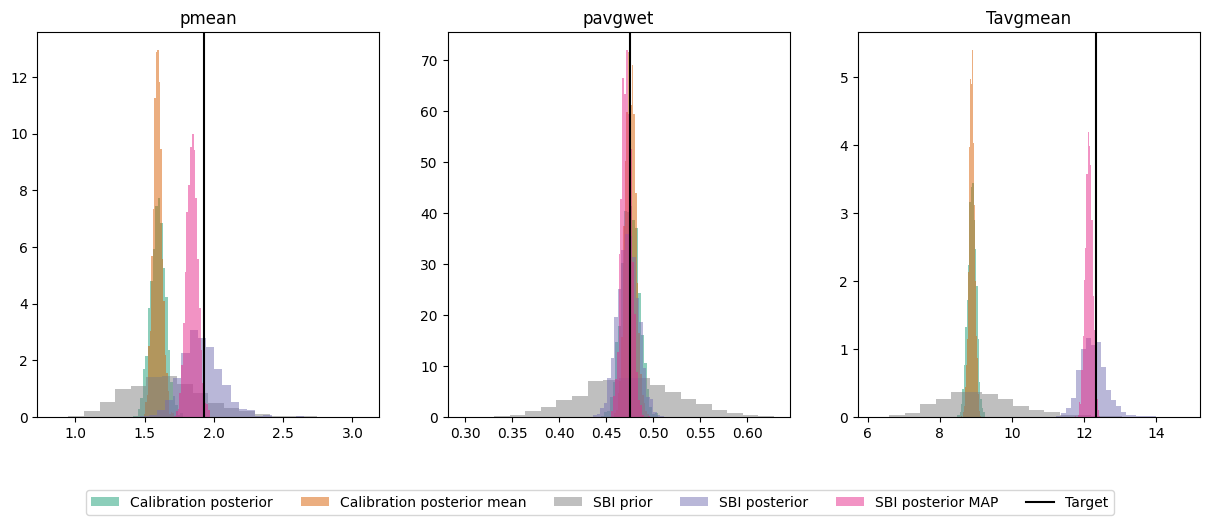

In [ ]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew"])

simulator = wxsbi.build_simulator(wgen, case_study_1a, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask)
result = wxsbi.run_sbi(simulator, obs_stats_target, prior = cm_prior, calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000, num_rounds = num_rounds, batch_size = 500, simulations_per_round = 1000)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_1b.pkl")

## Case study 2 (Tavg, pr, heavy rain, icy days, tropical night, Trange)

Note: $\gamma = 3.5$ here to make sure prior closer to target in statistic nr. 5 (tropical nights).

In [ ]:
num_rounds = 10

In [ ]:
@wxsbi.summarystats("Tavgmean", "pmean", "heavy_rain", "icy_days", "tropical_nights", "Trangemean")
def case_study_2(prec, Tmin, Tavg, Tmax, **kwargs):
    Tavgmean = jnp.mean(Tavg, axis = -1)
    
    pmean = jnp.mean(prec, axis = -1)
    heavy_rain = jnp.mean(prec > 20, axis = -1)

    icy_days = jnp.mean(Tmax < 0, axis = -1)
    tropical_nights = jnp.mean(Tmin > 20, axis = -1)

    Trangemean = jnp.mean(Tmax - Tmin, axis = -1)

    return jnp.stack([Tavgmean, pmean, heavy_rain, icy_days, tropical_nights, Trangemean], axis = -1)

obs_stats = case_study_2(**obs).flatten()
obs_stats

Array([8.8164406e+00, 1.6045674e+00, 7.2289160e-03, 6.6538885e-02,
       8.2146772e-04, 8.3254004e+00], dtype=float32)

In [ ]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].add(3.1) # Tavg 
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean 
obs_stats_target = obs_stats_target.at[2].mul(2.) # heavy_rain
obs_stats_target = obs_stats_target.at[3].set(0.01) # icy_days: 3 per year
obs_stats_target = obs_stats_target.at[4].set(0.08) # tropical_nights: 30 per year
obs_stats_target = obs_stats_target.at[5].mul(1.2) # Trangemean

obs_stats_target

Array([1.1916441e+01, 2.0859375e+00, 1.4457832e-02, 9.9999998e-03,
       7.9999998e-02, 9.9904804e+00], dtype=float32)

Run SBI:

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 8/8 [01:14<00:00,  9.37s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 8/8 [01:12<00:00,  9.03s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 8/8 [01:12<00:00,  9.07s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 4/4 [00:37<00:00,  9.26s/it]
INFO:wxsbi.wxsbi:Training estimator


 Training neural network. Epochs trained: 60

INFO:wxsbi.wxsbi:Starting round 2/10


 Neural network successfully converged after 64 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1970.38it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 4/4 [00:36<00:00,  9.20s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 91

INFO:wxsbi.wxsbi:Starting round 3/10


 Neural network successfully converged after 92 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1834.96it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 4/4 [00:36<00:00,  9.23s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 57

INFO:wxsbi.wxsbi:Starting round 4/10


 Neural network successfully converged after 58 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2016.23it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 4/4 [00:36<00:00,  9.15s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 24

INFO:wxsbi.wxsbi:Starting round 5/10


 Neural network successfully converged after 25 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2125.36it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 4/4 [00:35<00:00,  8.97s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 41

INFO:wxsbi.wxsbi:Starting round 6/10


 Neural network successfully converged after 42 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2082.64it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 4/4 [00:36<00:00,  9.13s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 43

INFO:wxsbi.wxsbi:Starting round 7/10


 Neural network successfully converged after 44 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1970.66it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 4/4 [00:36<00:00,  9.11s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 25

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 26 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1947.74it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 4/4 [00:36<00:00,  9.17s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 47

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 48 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2122.50it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 4/4 [00:37<00:00,  9.32s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 27

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 28 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2371.85it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 4/4 [00:36<00:00,  9.12s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:00<00:00, 2500.78it/s]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 8/8 [01:13<00:00,  9.15s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate
Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2220.73it/s]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 8/8 [01:12<00:00,  9.02s/it]


17.37800511519114


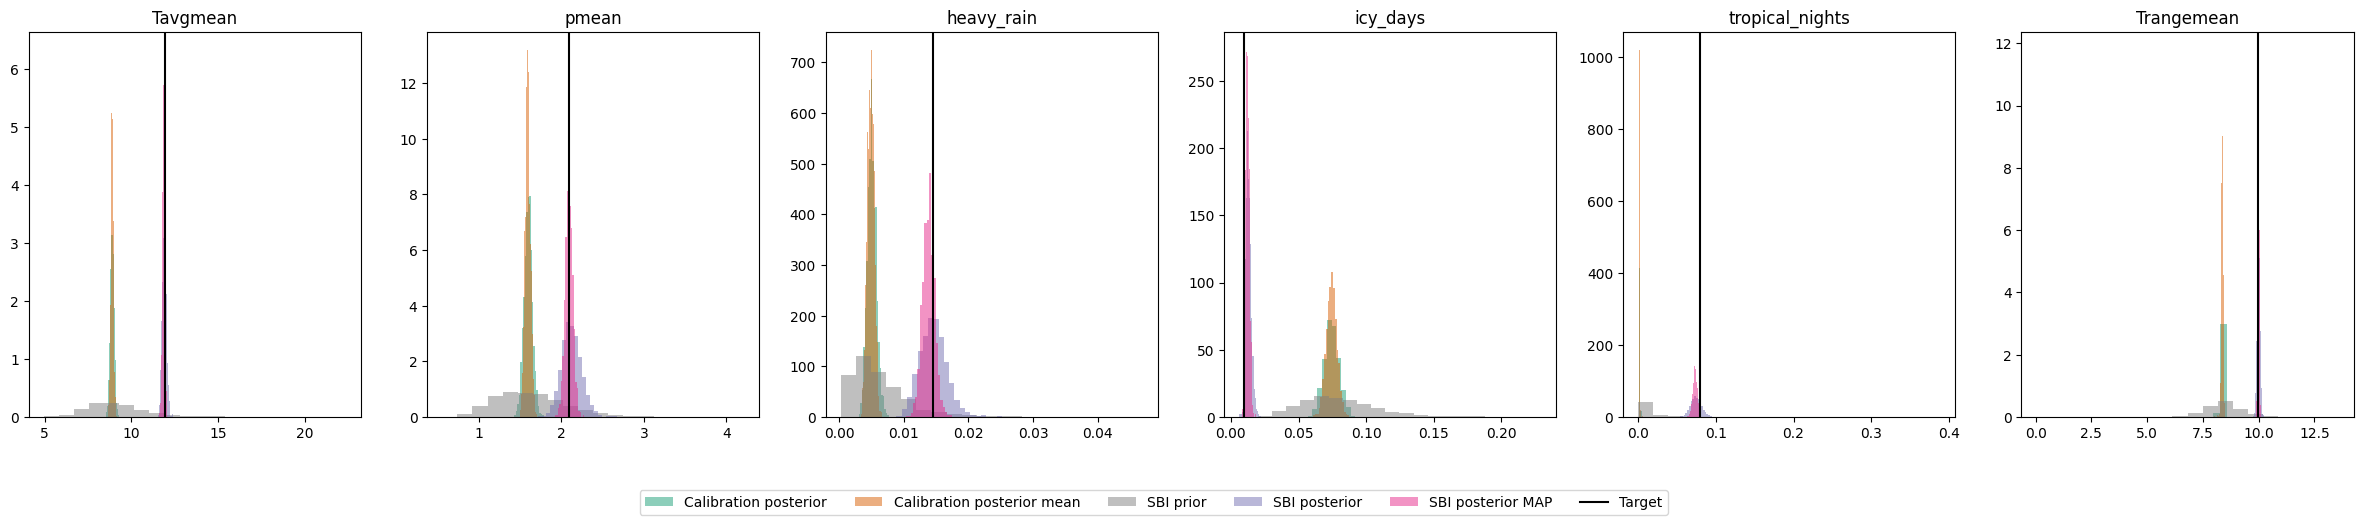

In [ ]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["seasonal"])

simulator = wxsbi.build_simulator(wgen, case_study_2, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask, scale_factor = 3.5)
result = wxsbi.run_sbi(simulator, obs_stats_target, prior = cm_prior, calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000, num_rounds = num_rounds, batch_size = 250, simulations_per_round = 1000)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_2.pkl")

## Case study 3a (seasonal Tavg, pr, monthly dry days const)

In [ ]:
num_rounds = 10

In [ ]:
@wxsbi.summarystats("pmean_winter", "pmean_spring", "pmean_summer", "pmean_autumn", "Tavg_winter", "Tavg_spring", "Tavg_summer", "Tavg_autumn", *list(map(str, range(1,13))))
def case_study_3a(t, prec, Tavg, **kwargs):
    winter = jnp.isin(t[:, :, 2], jnp.array([12, 1, 2]))
    spring = jnp.isin(t[:, :, 2], jnp.array([3, 4, 5]))
    summer = jnp.isin(t[:, :, 2], jnp.array([6, 7, 8]))
    autumn = jnp.isin(t[:, :, 2], jnp.array([9, 10, 11]))

    pmean_winter = jnp.nanmean(jnp.where(winter, prec, jnp.nan), axis = -1)
    pmean_spring = jnp.nanmean(jnp.where(spring, prec, jnp.nan), axis = -1)
    pmean_summer = jnp.nanmean(jnp.where(summer, prec, jnp.nan), axis = -1)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, prec, jnp.nan), axis = -1)

    wet = (prec > 0)
    
    monthly_pavg_wet = []
    for i in range(1, 13):
        month = (t[:, :, 2] == i)
        pavgwet_month = jnp.nanmean(jnp.where(month, wet, jnp.nan), axis = -1)
        monthly_pavg_wet.append(pavgwet_month)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = -1)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = -1)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = -1)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = -1)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn, *monthly_pavg_wet], axis = -1)#, icy_days])

obs_stats = case_study_3a(t = svi_preds['t'][:, :, :, :], **obs).mean(axis = 0).flatten()
obs_stats.shape

(20,)

In [ ]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

obs_stats_target

Array([ 1.9140847 ,  1.8918679 ,  2.075413  ,  1.6220819 ,  3.5786033 ,
       11.008173  , 20.57531   , 13.537079  ,  0.5668174 ,  0.5230332 ,
        0.45935452,  0.46266657,  0.4393549 ,  0.45333302,  0.4258063 ,
        0.4180644 ,  0.42666653,  0.4212904 ,  0.54133326,  0.5645161 ],      dtype=float32)

Run SBI:

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 4/4 [01:15<00:00, 18.84s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 4/4 [01:14<00:00, 18.58s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 4/4 [01:14<00:00, 18.60s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:38<00:00, 19.17s/it]
INFO:wxsbi.wxsbi:Training estimator


 Training neural network. Epochs trained: 88

INFO:wxsbi.wxsbi:Starting round 2/10


 Neural network successfully converged after 90 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2321.86it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:37<00:00, 18.86s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 55

INFO:wxsbi.wxsbi:Starting round 3/10


 Neural network successfully converged after 56 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2261.17it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:37<00:00, 18.95s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 54

INFO:wxsbi.wxsbi:Starting round 4/10


 Neural network successfully converged after 55 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2306.99it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:38<00:00, 19.03s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 41

INFO:wxsbi.wxsbi:Starting round 5/10


 Neural network successfully converged after 42 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2362.95it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:38<00:00, 19.17s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 53

INFO:wxsbi.wxsbi:Starting round 6/10


 Neural network successfully converged after 54 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2282.75it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:38<00:00, 19.05s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 33

INFO:wxsbi.wxsbi:Starting round 7/10


 Neural network successfully converged after 34 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2236.69it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:38<00:00, 19.09s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 29

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 30 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2204.84it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:38<00:00, 19.11s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 28

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 29 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2231.67it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:38<00:00, 19.31s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 71

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 72 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2094.79it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:38<00:00, 19.17s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.

Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:00<00:00, 2571.25it/s]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 4/4 [01:15<00:00, 18.87s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate
Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2263.27it/s]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 4/4 [01:15<00:00, 18.78s/it]


18.42202486594518


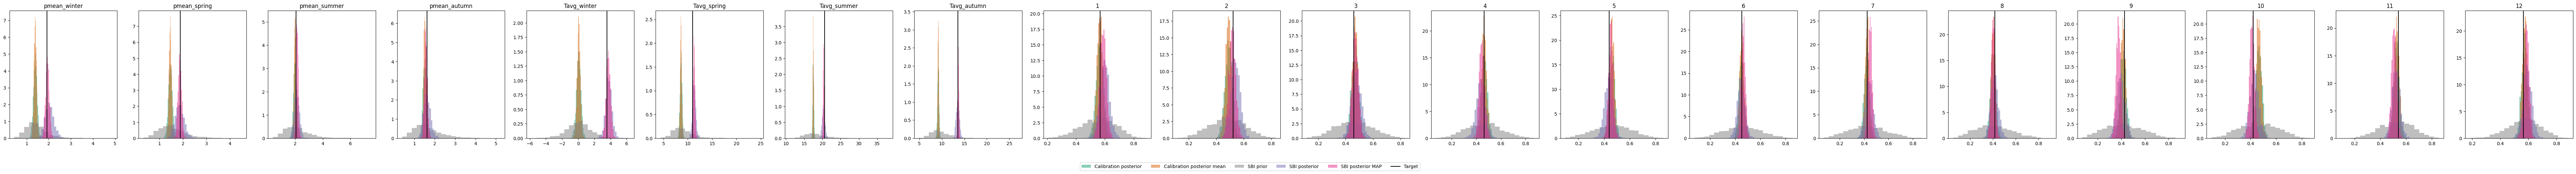

In [ ]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew"])

simulator = wxsbi.build_simulator(wgen, case_study_3a, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask, scale_factor = 2.5)
result = wxsbi.run_sbi(simulator, obs_stats_target, prior = cm_prior, calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000, num_rounds = num_rounds, batch_size = 500, simulations_per_round = 1000)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_3a.pkl")

## Case study 3b (seasonal Tavg, pr, overall dry days const, tight prior)

In [ ]:
num_rounds = 10

In [ ]:
@wxsbi.summarystats("pmean_winter", "pmean_spring", "pmean_summer", "pmean_autumn", "Tavg_winter", "Tavg_spring", "Tavg_summer", "Tavg_autumn", "pavg_wet")
def case_study_3b(t, prec, Tavg, **kwargs):
    winter = jnp.isin(t[:, :, 2], jnp.array([12, 1, 2]))
    spring = jnp.isin(t[:, :, 2], jnp.array([3, 4, 5]))
    summer = jnp.isin(t[:, :, 2], jnp.array([6, 7, 8]))
    autumn = jnp.isin(t[:, :, 2], jnp.array([9, 10, 11]))

    pmean_winter = jnp.nanmean(jnp.where(winter, prec, jnp.nan), axis = -1)
    pmean_spring = jnp.nanmean(jnp.where(spring, prec, jnp.nan), axis = -1)
    pmean_summer = jnp.nanmean(jnp.where(summer, prec, jnp.nan), axis = -1)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, prec, jnp.nan), axis = -1)

    wet = (prec > 0)
    pavg_wet = jnp.nanmean(wet, axis = -1)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = -1)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = -1)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = -1)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = -1)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn, pavg_wet], axis = -1)#, icy_days])

obs_stats = case_study_3b(
    t = svi_preds['t'][:, :, :, :], 
    prec = jnp.broadcast_to(obs['prec'], (svi_preds['t'].shape[0], obs['prec'].shape[1])),
    Tavg = jnp.broadcast_to(obs['Tavg'], (svi_preds['t'].shape[0], obs['Tavg'].shape[1]))
    ).mean(axis = 0).flatten()
obs_stats

Array([ 1.4723729 ,  1.455283  ,  2.075413  ,  1.410506  ,  0.17860317,
        8.408174  , 17.47531   ,  9.037079  ,  0.47486308], dtype=float32)

In [ ]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

obs_stats_target

Array([ 1.9140847 ,  1.8918679 ,  2.075413  ,  1.6220819 ,  3.5786033 ,
       11.008173  , 20.57531   , 13.537079  ,  0.47486308], dtype=float32)

Run SBI:

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 4/4 [01:15<00:00, 18.89s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 4/4 [01:22<00:00, 20.70s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 4/4 [01:25<00:00, 21.36s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:42<00:00, 21.10s/it]
INFO:wxsbi.wxsbi:Training estimator


 Training neural network. Epochs trained: 67

INFO:wxsbi.wxsbi:Starting round 2/10


 Neural network successfully converged after 69 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1355.51it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:44<00:00, 22.35s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 41

INFO:wxsbi.wxsbi:Starting round 3/10


 Neural network successfully converged after 42 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1251.82it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:44<00:00, 22.36s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 105

INFO:wxsbi.wxsbi:Starting round 4/10


 Neural network successfully converged after 106 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1254.32it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:44<00:00, 22.36s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 41

INFO:wxsbi.wxsbi:Starting round 5/10


 Neural network successfully converged after 42 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1199.29it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:45<00:00, 22.53s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 25

INFO:wxsbi.wxsbi:Starting round 6/10


 Neural network successfully converged after 26 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1226.84it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:43<00:00, 21.62s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 33

INFO:wxsbi.wxsbi:Starting round 7/10


 Neural network successfully converged after 34 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1217.89it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:43<00:00, 21.93s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 34

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 35 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1147.19it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:44<00:00, 22.41s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 56

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 57 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1241.49it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:45<00:00, 22.57s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 75

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 76 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1250.97it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:43<00:00, 21.97s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:01<00:00, 1541.59it/s]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 4/4 [01:29<00:00, 22.29s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate
Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1266.05it/s]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 4/4 [01:31<00:00, 22.82s/it]


23.550047167142232


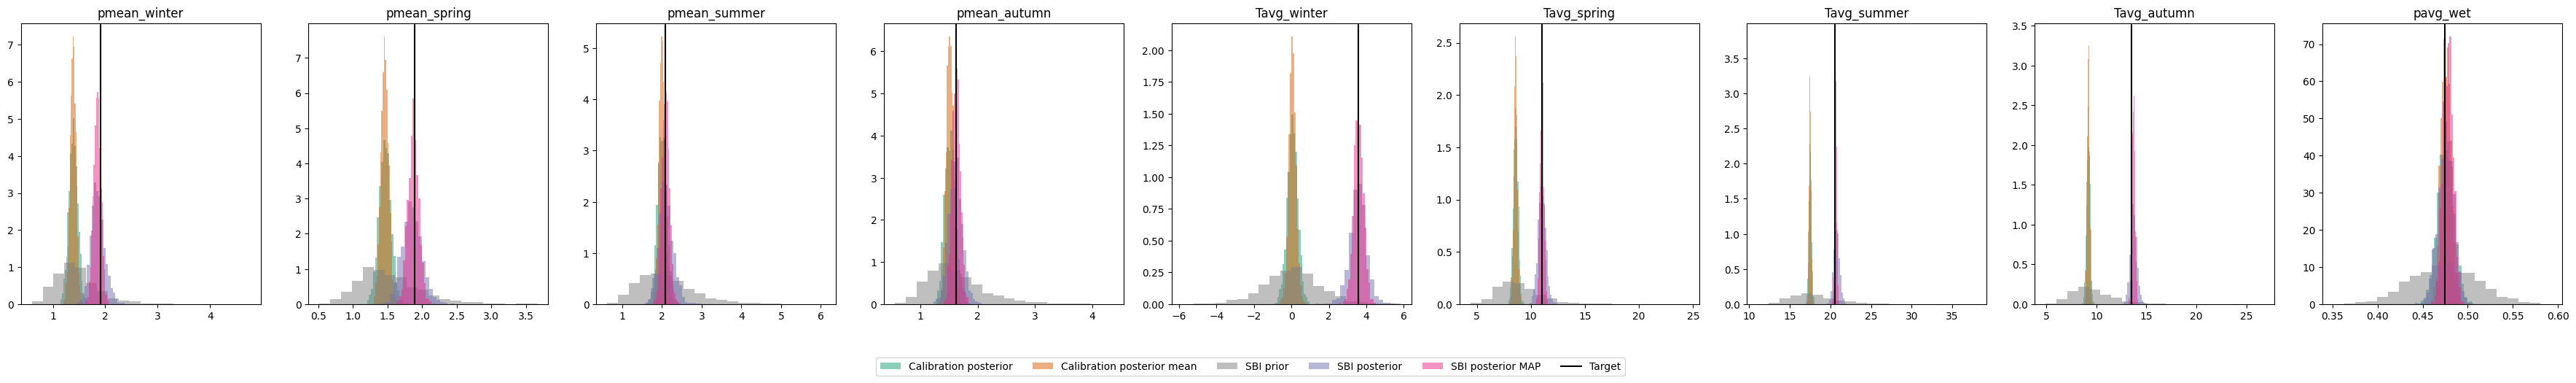

In [ ]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew", "precip_occ_"])

simulator = wxsbi.build_simulator(wgen, case_study_3b, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask, scale_factor = 2.5)
result = wxsbi.run_sbi(simulator, obs_stats_target, prior = cm_prior, calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000, num_rounds = num_rounds, batch_size = 500, simulations_per_round = 1000)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_3b.pkl")

## Case study 3c (seasonal Tavg, pr, overall dry days const, large prior)

In [17]:
num_rounds = 10

In [18]:
@wxsbi.summarystats("pmean_winter", "pmean_spring", "pmean_summer", "pmean_autumn", "Tavg_winter", "Tavg_spring", "Tavg_summer", "Tavg_autumn", "pavg_wet")
def case_study_3c(t, prec, Tavg, **kwargs):
    winter = jnp.isin(t[:, :, 2], jnp.array([12, 1, 2]))
    spring = jnp.isin(t[:, :, 2], jnp.array([3, 4, 5]))
    summer = jnp.isin(t[:, :, 2], jnp.array([6, 7, 8]))
    autumn = jnp.isin(t[:, :, 2], jnp.array([9, 10, 11]))

    pmean_winter = jnp.nanmean(jnp.where(winter, prec, jnp.nan), axis = -1)
    pmean_spring = jnp.nanmean(jnp.where(spring, prec, jnp.nan), axis = -1)
    pmean_summer = jnp.nanmean(jnp.where(summer, prec, jnp.nan), axis = -1)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, prec, jnp.nan), axis = -1)

    wet = (prec > 0)
    pavg_wet = jnp.nanmean(wet, axis = -1)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = -1)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = -1)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = -1)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = -1)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn, pavg_wet], axis = -1)#, icy_days])

obs_stats = case_study_3c(
    t = svi_preds['t'][:, :, :, :], 
    prec = jnp.broadcast_to(obs['prec'], (svi_preds['t'].shape[0], obs['prec'].shape[1])),
    Tavg = jnp.broadcast_to(obs['Tavg'], (svi_preds['t'].shape[0], obs['Tavg'].shape[1]))
    ).mean(axis = 0).flatten()
obs_stats

Array([ 1.4723729 ,  1.455283  ,  2.075413  ,  1.410506  ,  0.17860317,
        8.408174  , 17.47531   ,  9.037079  ,  0.47486308], dtype=float32)

In [19]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

obs_stats_target

Array([ 1.9140847 ,  1.8918679 ,  2.075413  ,  1.6220819 ,  3.5786033 ,
       11.008173  , 20.57531   , 13.537079  ,  0.47486308], dtype=float32)

Run SBI:

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 4/4 [01:15<00:00, 18.77s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 4/4 [01:13<00:00, 18.42s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 4/4 [01:13<00:00, 18.46s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:38<00:00, 19.19s/it]
INFO:wxsbi.wxsbi:Training estimator


 Training neural network. Epochs trained: 68

INFO:wxsbi.wxsbi:Starting round 2/10


 Neural network successfully converged after 72 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1900.96it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:37<00:00, 18.97s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 45

INFO:wxsbi.wxsbi:Starting round 3/10


 Neural network successfully converged after 46 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2071.93it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:37<00:00, 18.84s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 37

INFO:wxsbi.wxsbi:Starting round 4/10


 Neural network successfully converged after 38 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2211.34it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:38<00:00, 19.46s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 42

INFO:wxsbi.wxsbi:Starting round 5/10


 Neural network successfully converged after 43 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2087.97it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:37<00:00, 18.77s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 49

INFO:wxsbi.wxsbi:Starting round 6/10


 Neural network successfully converged after 50 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2046.55it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:37<00:00, 18.92s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 42

INFO:wxsbi.wxsbi:Starting round 7/10


 Neural network successfully converged after 43 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2225.05it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:38<00:00, 19.02s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 25

INFO:wxsbi.wxsbi:Starting round 8/10


 Neural network successfully converged after 26 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2200.70it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:37<00:00, 18.94s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 55

INFO:wxsbi.wxsbi:Starting round 9/10


 Neural network successfully converged after 56 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2171.11it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:37<00:00, 18.98s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 35

INFO:wxsbi.wxsbi:Starting round 10/10


 Neural network successfully converged after 36 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2193.17it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:38<00:00, 19.23s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 49 epochs.

Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:00<00:00, 2512.95it/s]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 4/4 [01:15<00:00, 18.78s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate
Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1942.18it/s]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 4/4 [01:13<00:00, 18.49s/it]


18.23741204738617


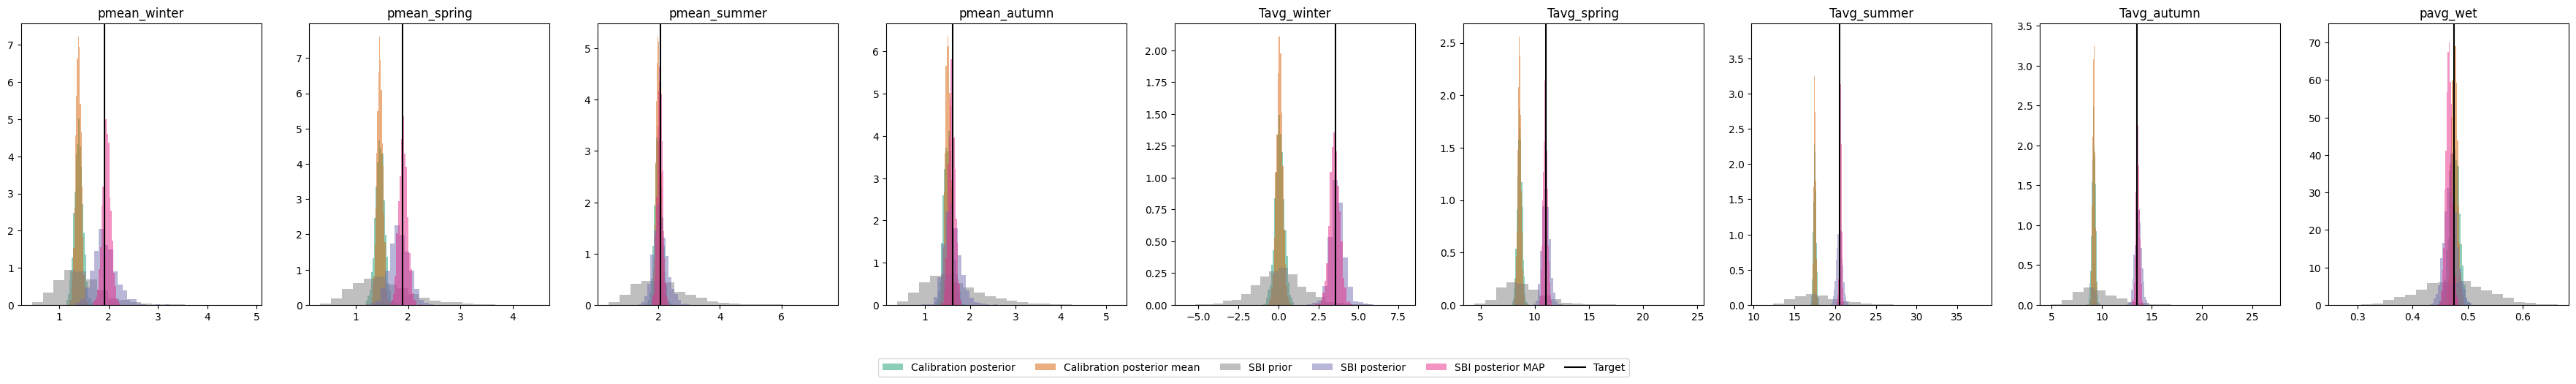

In [20]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew"])

simulator = wxsbi.build_simulator(wgen, case_study_3c, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask, scale_factor = 2.5)
result = wxsbi.run_sbi(simulator, obs_stats_target, prior = cm_prior, calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000, num_rounds = num_rounds, batch_size = 500, simulations_per_round = 1000)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_3c.pkl")

## Case study 3d (seasonal Tavg, pr)

In [21]:
num_rounds = 10

In [22]:
@wxsbi.summarystats("pmean_winter", "pmean_spring", "pmean_summer", "pmean_autumn", "Tavg_winter", "Tavg_spring", "Tavg_summer", "Tavg_autumn", "pavg_wet")
def case_study_3d(t, prec, Tavg, **kwargs):
    winter = jnp.isin(t[:, :, 2], jnp.array([12, 1, 2]))
    spring = jnp.isin(t[:, :, 2], jnp.array([3, 4, 5]))
    summer = jnp.isin(t[:, :, 2], jnp.array([6, 7, 8]))
    autumn = jnp.isin(t[:, :, 2], jnp.array([9, 10, 11]))

    pmean_winter = jnp.nanmean(jnp.where(winter, prec, jnp.nan), axis = -1)
    pmean_spring = jnp.nanmean(jnp.where(spring, prec, jnp.nan), axis = -1)
    pmean_summer = jnp.nanmean(jnp.where(summer, prec, jnp.nan), axis = -1)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, prec, jnp.nan), axis = -1)

    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = -1)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = -1)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = -1)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = -1)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn], axis = -1)#, icy_days])

obs_stats = case_study_3d(
    t = svi_preds['t'][:, :, :, :], 
    prec = jnp.broadcast_to(obs['prec'], (svi_preds['t'].shape[0], obs['prec'].shape[1])),
    Tavg = jnp.broadcast_to(obs['Tavg'], (svi_preds['t'].shape[0], obs['Tavg'].shape[1]))
    ).mean(axis = 0).flatten()
obs_stats

Array([ 1.4723729 ,  1.455283  ,  2.075413  ,  1.410506  ,  0.17860317,
        8.408174  , 17.47531   ,  9.037079  ], dtype=float32)

In [23]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

obs_stats_target

Array([ 1.9140847,  1.8918679,  2.075413 ,  1.6220819,  3.5786033,
       11.008173 , 20.57531  , 13.537079 ], dtype=float32)

Run SBI:

In [ ]:
import time
start = time.time()

parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew"])

simulator = wxsbi.build_simulator(wgen, case_study_3d, parallel = True)
cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask, scale_factor = 2.5)
result = wxsbi.run_sbi(simulator, obs_stats_target, prior = cm_prior, calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000, num_rounds = num_rounds, batch_size = 500, simulations_per_round = 1000)

end = time.time()
print((end-start)/60)

wxsbi.plot_target_densitites_sbi(result)
result.to_file("sbi_results/case_study_3d.pkl")

INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 4/4 [01:18<00:00, 19.68s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 4/4 [01:15<00:00, 18.99s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 4/4 [01:15<00:00, 18.92s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/10
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:40<00:00, 20.12s/it]
INFO:wxsbi.wxsbi:Training estimator


 Training neural network. Epochs trained: 68

INFO:wxsbi.wxsbi:Starting round 2/10


 Neural network successfully converged after 72 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1975.35it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:39<00:00, 19.52s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 77

INFO:wxsbi.wxsbi:Starting round 3/10


 Neural network successfully converged after 78 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2019.19it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:38<00:00, 19.45s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 51

INFO:wxsbi.wxsbi:Starting round 4/10


 Neural network successfully converged after 52 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1855.77it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
  0%|          | 0/2 [00:00<?, ?it/s]

# Analysis

In [12]:
def make_line_plots(fut, hist, obs, time, target = None, ax = None, color_fut = "lightblue"):
    if ax is None:
        fig, ax = plt.subplots(figsize = (6,4))
        
    df_preds = pd.DataFrame(fut.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars="time", value_name="pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable]).mean().drop(columns="time").reset_index()
    sns.lineplot(df_preds, x = "time", y = "pred", units = "variable", estimator = None, color = color_fut, alpha = 0.2, ax = ax)
    
    df_preds = pd.DataFrame(hist.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars="time", value_name="pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable]).mean().drop(columns="time").reset_index()
    sns.lineplot(df_preds, x = "time", y = "pred", units = "variable", estimator = None, color = "grey", alpha = 0.2, ax = ax)
    
    df_obs = pd.DataFrame({"obs": obs.squeeze(), "time": basin_data_train.index})
    df_obs = df_obs.groupby(df_obs.time.dt.month)["obs"].mean().reset_index()
    sns.lineplot(df_obs, x="time", y="obs", color = "black", ax = ax)

    if target is not None:
        ax.axhline(target, color = "darkblue", linestyle = "dashed")

def add_seasonal_targets(targets, ax):
    ax.hlines(y = targets[0], xmin = 1, xmax = 2.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[1], xmin = 2.5, xmax = 5.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[2], xmin = 5.5, xmax = 8.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[3], xmin = 8.5, xmax = 11.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[0], xmin = 11.5, xmax = 12, color = "darkblue", linestyle = "dashed")

def add_monthly_targets(targets, ax):
    for i in range(2, 12):
        ax.hlines(y = targets[i-1], xmin = i-0.5, xmax = i+0.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[0], xmin = 1, xmax = 1.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[11], xmin = 11.5, xmax = 12, color = "darkblue", linestyle = "dashed")


## Case study 1

In [9]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_1a.pkl")

In [10]:
obs_stats_target = result.summary_target

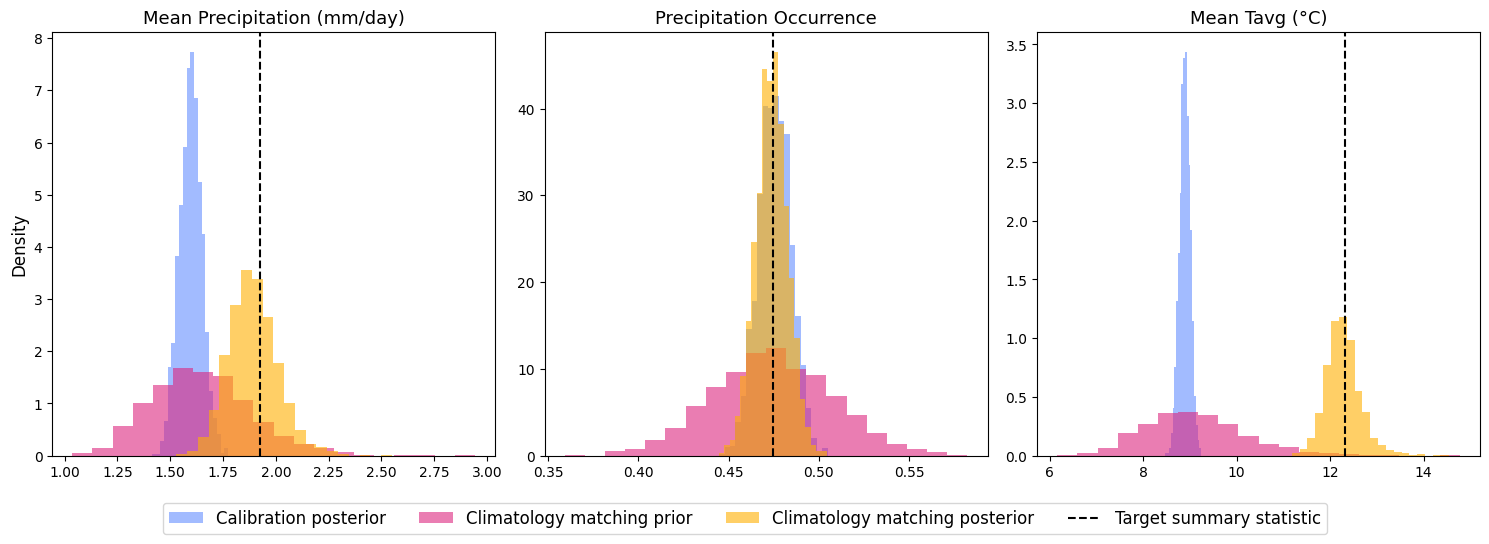

In [ ]:
import matplotlib.pyplot as plt

# Colorblind-safe Paul Tol "Bright" palette
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

# Plot
titles = ["Mean Precipitation (mm/day)", "Precipitation Occurrence", "Mean Tavg (°C)"]

fig, axs = plt.subplots(
    1, obs_stats_target.shape[0],
    figsize=(obs_stats_target.shape[0] * 5, 5),
    layout="tight"
)

for i in range(obs_stats_target.shape[0]):
    axs[i].hist(
        result.simulations["calibration_posterior"][:, i],
        bins=20, density=True, alpha=0.6,
        color=colors["calibration_posterior"],
        label="Calibration posterior"
    )
    axs[i].hist(
        result.simulations["sbi_prior"][:, i],
        bins=20, density=True, alpha=0.6,
        color=colors["sbi_prior"],
        label="Climatology matching prior"
    )
    axs[i].hist(
        result.simulations["sbi_posterior"][:, i],
        bins=20, density=True, alpha=0.6,
        color=colors["sbi_posterior"],
        label="Climatology matching posterior"
    )

    axs[i].axvline(
        obs_stats_target[i],
        color="black", linestyle="--", linewidth=1.5,
        label="Target summary statistic"
    )

    axs[i].set_title(titles[i], fontsize=13)
    #axs[i].grid(alpha=0.3)

#axs[0].set_xlabel("Mean Precipitation (mm/day)", fontsize=12)
#axs[1].set_xlabel("Precipitation Occurrence", fontsize=12)
#axs[2].set_xlabel("Mean Tavg (°C)", fontsize=12)
axs[0].set_ylabel("Density", fontsize=12)
#axs[1].set_ylabel("Density", fontsize=12)
#axs[2].set_ylabel("Density", fontsize=12)

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Shared legend below the plots, with box
fig.legend(
    by_label.values(), by_label.keys(),
    loc="upper center", bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=False, ncol=4, frameon=True,
    fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_1.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
ts = result.simulate_ts('sbi_posterior_map', 'calibration_posterior_mean', observables = ['prec', 'Tavg'], num_samples=10, from_parameter_samples = False)

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2157.39it/s]


In [12]:
obs_hist = ts["calibration_posterior_mean"]
obs_fut = ts["sbi_posterior_map"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

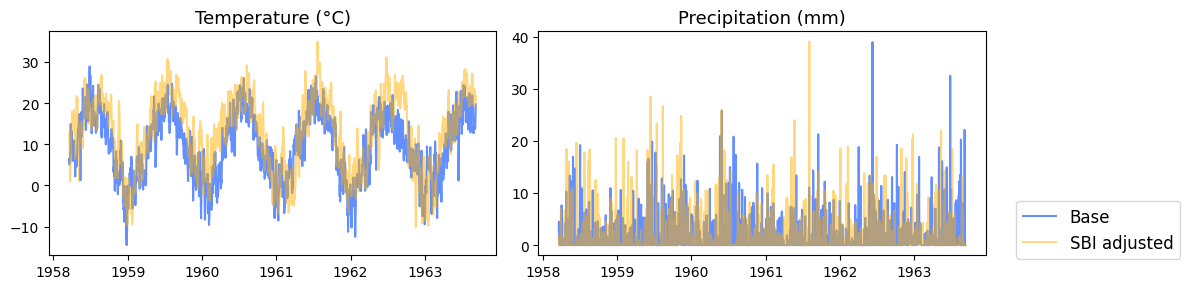

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 3), layout = "tight")

ax1.plot(basin_data_train.index[3000:5000], tavg_hist[0, 3000:5000], label = "Base", color = '#648FFF')
ax1.plot(basin_data_train.index[3000:5000], tavg_fut[1, 3000:5000], alpha = 0.5, label = "SBI adjusted", color = '#FFB000')
ax1.set_title("Temperature (°C)", fontsize = 13)

ax2.plot(basin_data_train.index[3000:5000], pr_hist[0, 3000:5000], label = "Base", color = '#648FFF')
ax2.plot(basin_data_train.index[3000:5000], pr_fut[1, 3000:5000], alpha = 0.5, label = "SBI adjusted", color = '#FFB000')
ax2.legend(bbox_to_anchor = (1.05, 0.28), fontsize = 12)
ax2.set_title("Precipitation (mm)", fontsize = 13)

plt.savefig("plots/analysis_v2/case_study_1_temp_precip.png")

## Case study 2

In [27]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_2.pkl")

In [28]:
obs_stats_target = result.summary_target

Case study 2:

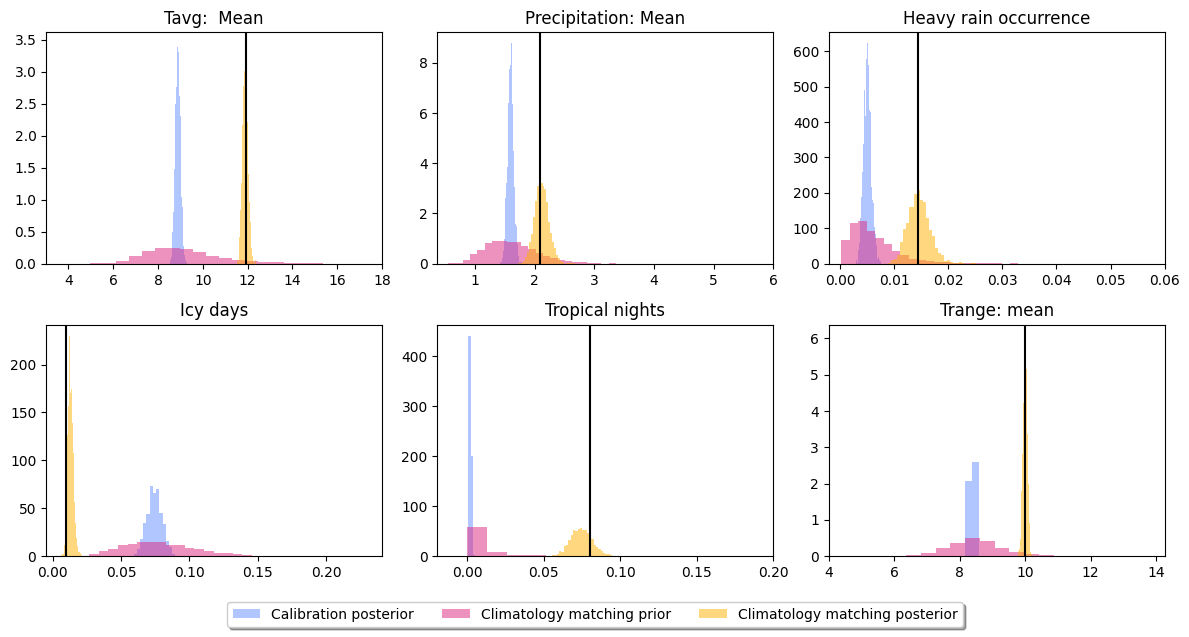

In [30]:
# Plot
colours = ["#648FFF", "#DC267F", "#FFB000"]

titles = ["Tavg:  Mean", "Precipitation: Mean", "Heavy rain occurrence", "Icy days", "Tropical nights", "Trange: mean"]
left_xlims = [3, None, None, None, None, 4]
right_xlims = [18, 6, 0.06, None, 0.2, None]

fig, axs = plt.subplots(2, 3, figsize = (12, 6), layout = "tight")
axs = axs.ravel()
for i in range(obs_stats_target.shape[0]):
    axs[i].hist(result.simulations["calibration_posterior"][:, i], bins = 30, density = True, alpha = 0.5, label = "Calibration posterior", color = colours[0])
    axs[i].hist(result.simulations["sbi_prior"][:, i], bins = 30, density = True, alpha = 0.5, label = "Climatology matching prior", color = colours[1])
    axs[i].hist(result.simulations["sbi_posterior"][:, i], bins = 30, density = True, alpha = 0.5, label = "Climatology matching posterior", color = colours[2])
    #axs[i].legend(loc = "upper right")
    axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target[i].flatten(), c= "black")
    axs[i].set_xlim(left = left_xlims[i], right = right_xlims[i])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.0),
          fancybox=True, shadow=True, ncol=5)
plt.savefig("plots/analysis_v2/case_study_2.png", dpi = 300, bbox_inches='tight')


## Case study 3

### Overview part a)

In [13]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_3a.pkl")
obs_stats_target = result.summary_target


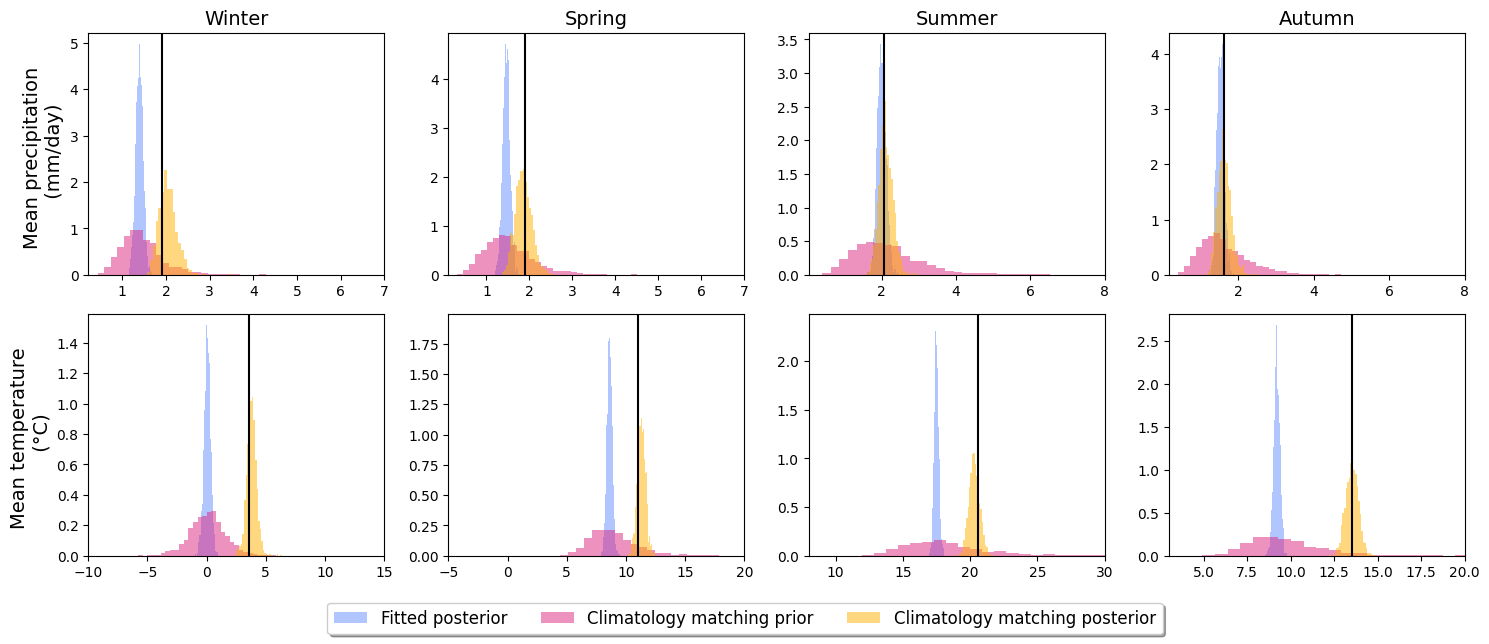

In [14]:
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = result.simulations["calibration_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = result.simulations["sbi_prior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = result.simulations["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target[jnp.array(idxs)]

# Color palette
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation \n (mm/day)", fontsize = 14)
axs[1, 0].set_ylabel("Mean temperature \n (°C)", fontsize = 14)

axs = axs.ravel()
axs[0].set_title("Winter", fontsize = 14)
axs[1].set_title("Spring", fontsize = 14)
axs[2].set_title("Summer", fontsize = 14)
axs[3].set_title("Autumn", fontsize = 14)

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(
        samples_summary_stats_reduced_plot["fitted_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["calibration_posterior"], label="Fitted posterior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_proposal"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_prior"], label="Climatology matching prior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_posterior"], label="Climatology matching posterior"
    )
    axs[i].axvline(obs_stats_target_reduced_plot[i].flatten(), color="black")
    axs[i].set_xlim(left=left_xlims[i], right=right_xlims[i])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    loc='upper center', bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=True, ncol=5, fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_3a.png", dpi=300, bbox_inches='tight')

In [15]:
ts = result.simulate_ts('sbi_posterior', 'sbi_posterior_map', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)

obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior_map"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1950.69it/s]


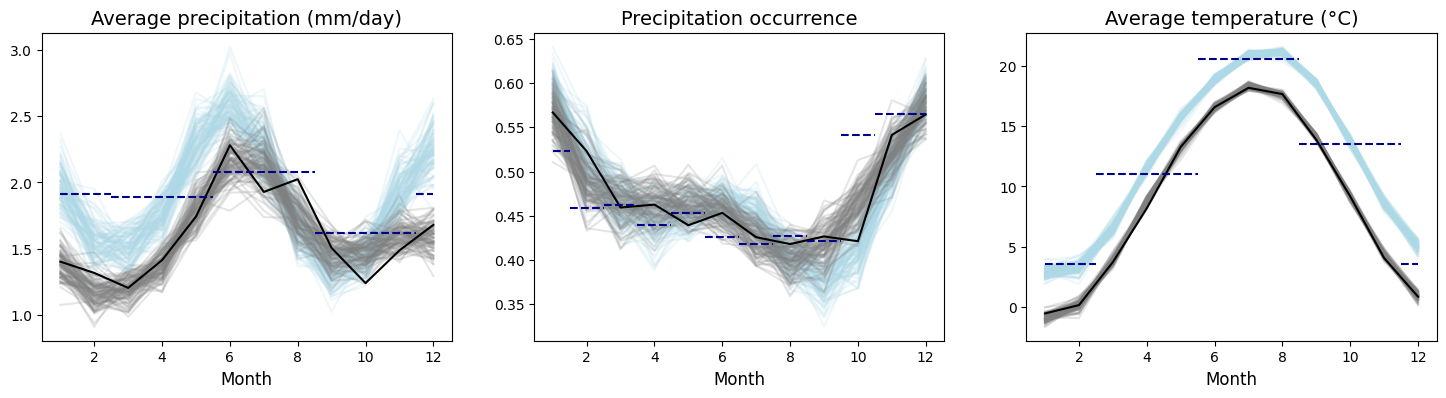

In [16]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
add_monthly_targets(obs_stats_target[9:], axs[1])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:9], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3a_ensemble.png", dpi=300, bbox_inches='tight')

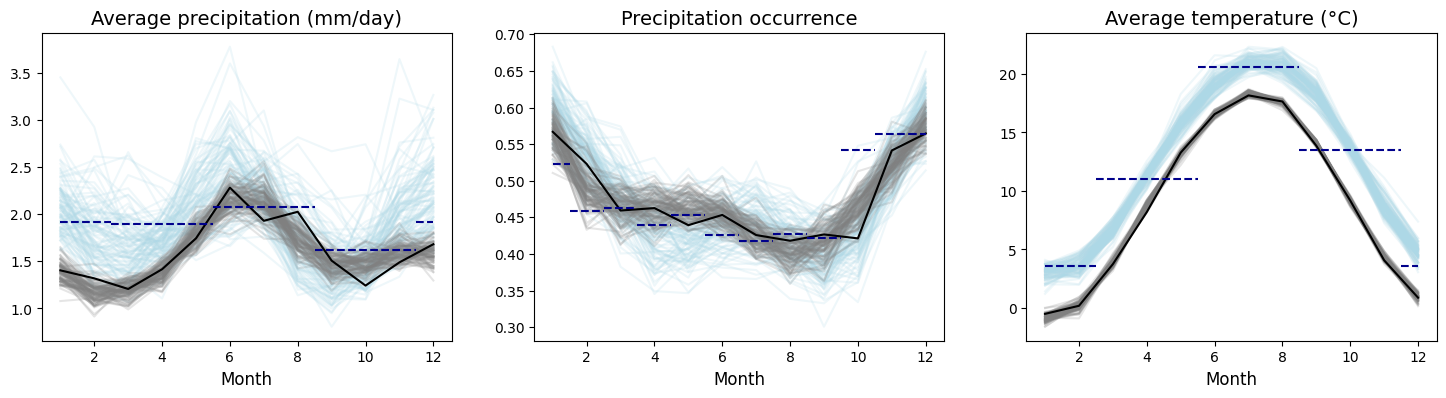

In [17]:
obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
add_monthly_targets(obs_stats_target[9:], axs[1])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:9], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3a_ensemble_full_posterior.png", dpi=300, bbox_inches='tight')

### Overview part b)

In [18]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_3b.pkl")
obs_stats_target = result.summary_target


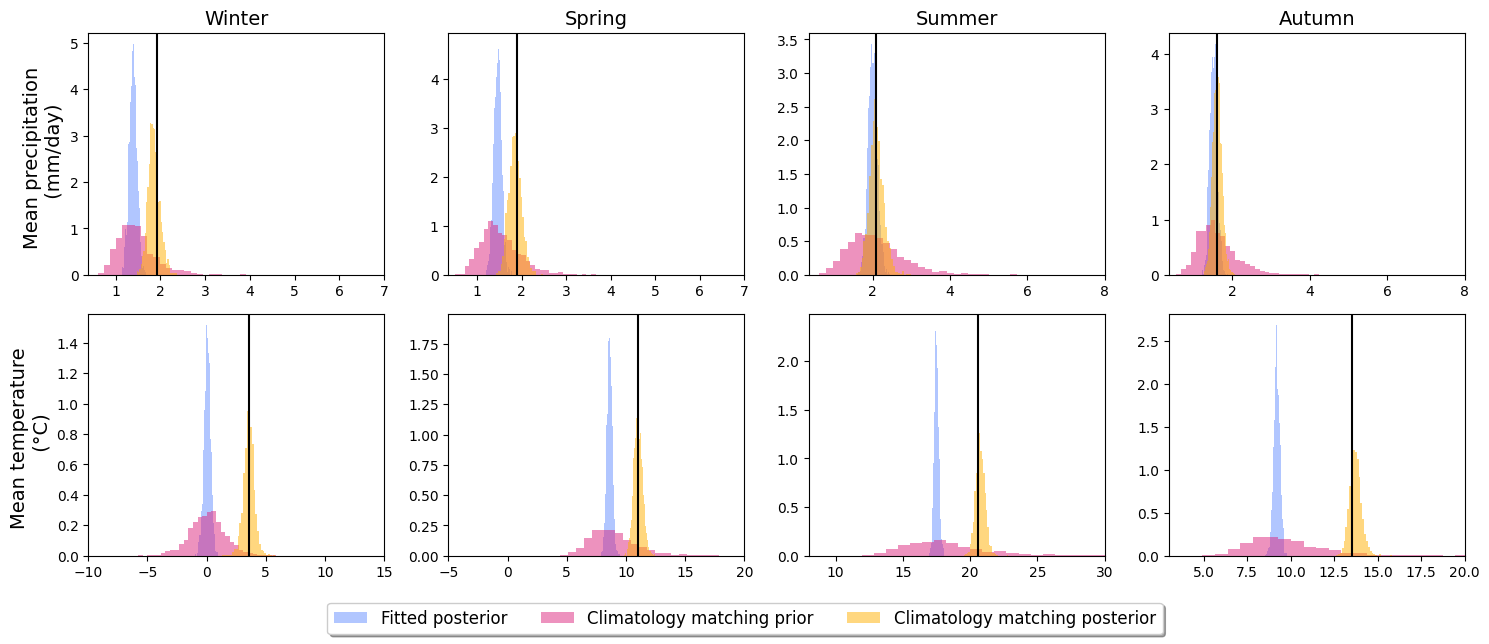

In [19]:
# Plot
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = result.simulations["calibration_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = result.simulations["sbi_prior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = result.simulations["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target[jnp.array(idxs)]

# Color palette
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation \n (mm/day)", fontsize = 14)
axs[1, 0].set_ylabel("Mean temperature \n (°C)", fontsize = 14)

axs = axs.ravel()
axs[0].set_title("Winter", fontsize = 14)
axs[1].set_title("Spring", fontsize = 14)
axs[2].set_title("Summer", fontsize = 14)
axs[3].set_title("Autumn", fontsize = 14)

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(
        samples_summary_stats_reduced_plot["fitted_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["calibration_posterior"], label="Fitted posterior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_proposal"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_prior"], label="Climatology matching prior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_posterior"], label="Climatology matching posterior"
    )
    axs[i].axvline(obs_stats_target_reduced_plot[i].flatten(), color="black")
    axs[i].set_xlim(left=left_xlims[i], right=right_xlims[i])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    loc='upper center', bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=True, ncol=5, fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_3b.png", dpi=300, bbox_inches='tight')

In [20]:
ts = result.simulate_ts('sbi_posterior', 'sbi_posterior_map', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)

obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior_map"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2311.09it/s]


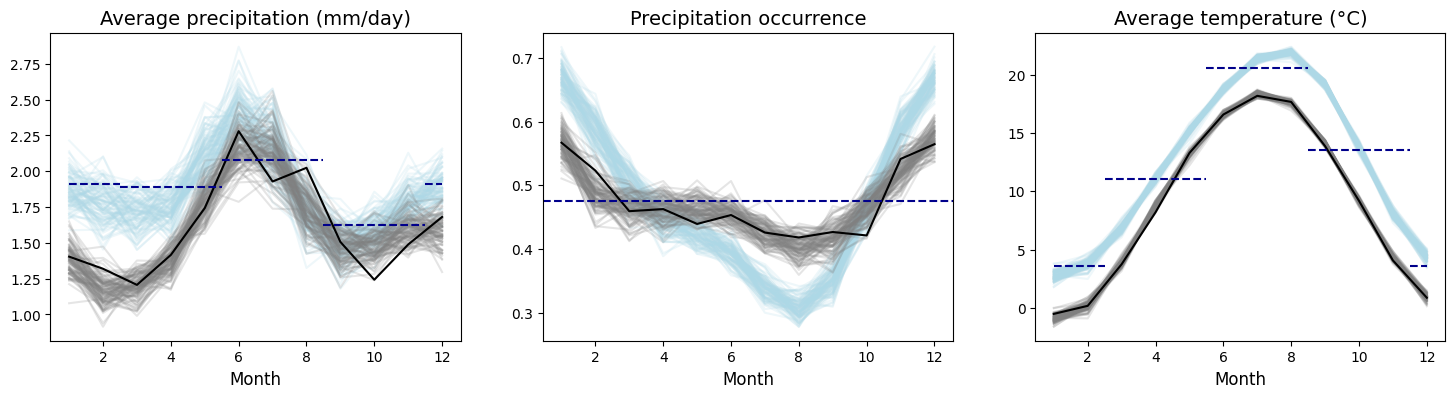

In [21]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1], target = obs_stats_target[-1])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3b_ensemble.png", dpi=300, bbox_inches='tight')

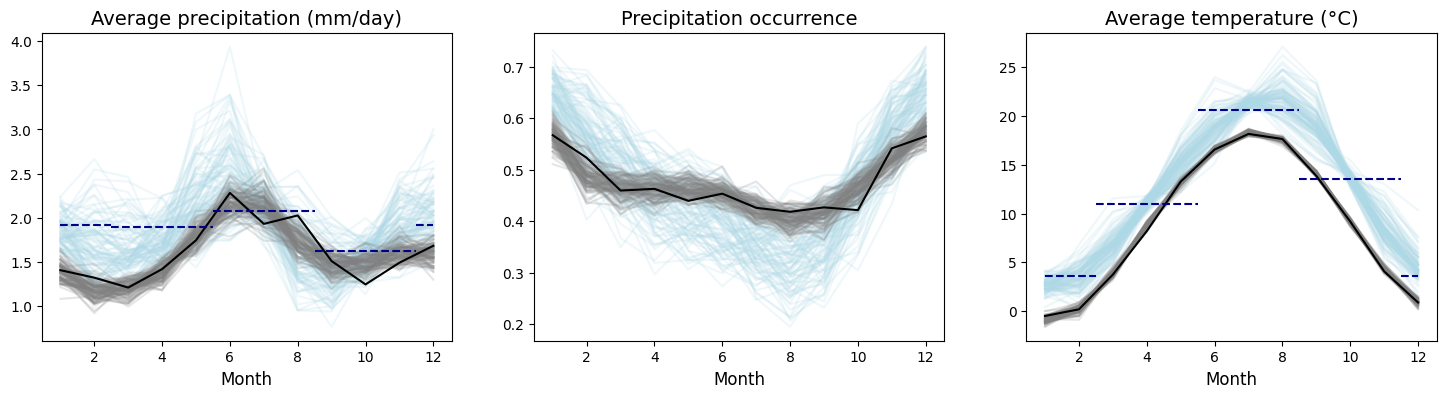

In [22]:
obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3b_ensemble_full_posterior.png", dpi=300, bbox_inches='tight')

### Overview part c)

In [13]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_3c.pkl")
obs_stats_target = result.summary_target


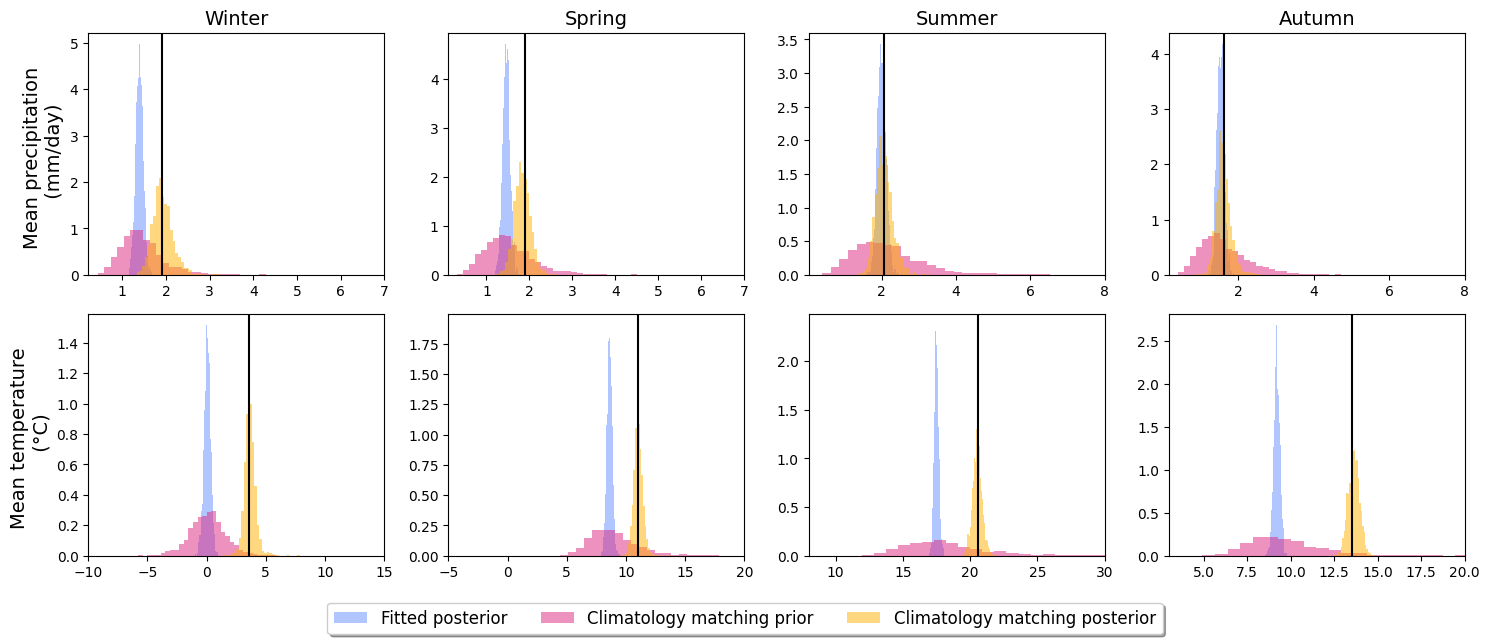

In [14]:
# Plot
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = result.simulations["calibration_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = result.simulations["sbi_prior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = result.simulations["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target[jnp.array(idxs)]

# Color palette
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation \n (mm/day)", fontsize = 14)
axs[1, 0].set_ylabel("Mean temperature \n (°C)", fontsize = 14)

axs = axs.ravel()
axs[0].set_title("Winter", fontsize = 14)
axs[1].set_title("Spring", fontsize = 14)
axs[2].set_title("Summer", fontsize = 14)
axs[3].set_title("Autumn", fontsize = 14)

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(
        samples_summary_stats_reduced_plot["fitted_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["calibration_posterior"], label="Fitted posterior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_proposal"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_prior"], label="Climatology matching prior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_posterior"], label="Climatology matching posterior"
    )
    axs[i].axvline(obs_stats_target_reduced_plot[i].flatten(), color="black")
    axs[i].set_xlim(left=left_xlims[i], right=right_xlims[i])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    loc='upper center', bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=True, ncol=5, fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_3c.png", dpi=300, bbox_inches='tight')

In [15]:
ts = result.simulate_ts('sbi_posterior', 'sbi_posterior_map', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)

obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior_map"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1956.15it/s]


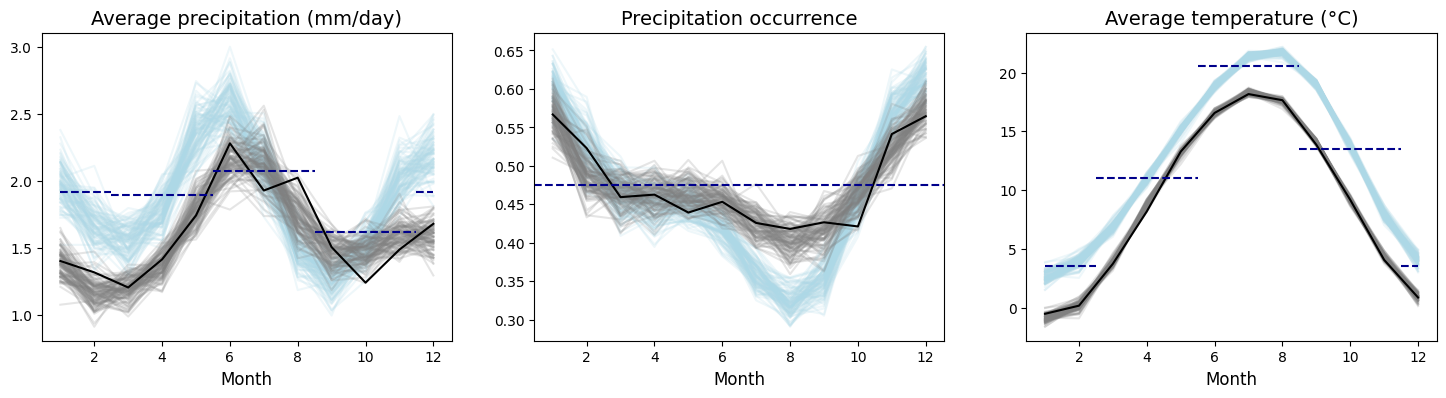

In [16]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1], target = obs_stats_target[9])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3c_ensemble.png", dpi=300, bbox_inches='tight')

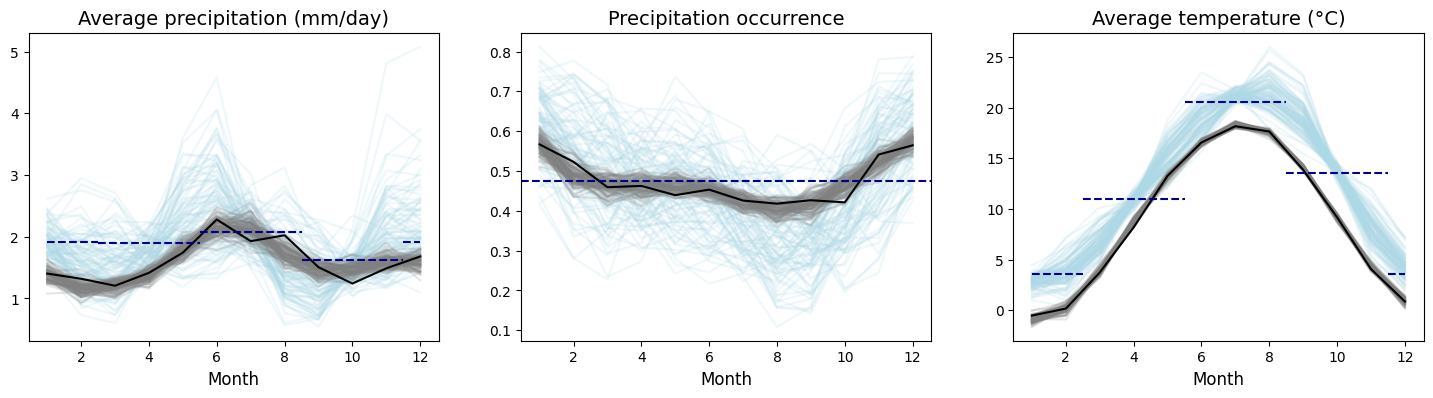

In [17]:
obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1], target = obs_stats_target[9])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3c_ensemble_full_posterior.png", dpi=300, bbox_inches='tight')

### Overview part d)

In [18]:
result = wxsbi.SBIResults.from_file("sbi_results/case_study_3d.pkl")
obs_stats_target = result.summary_target


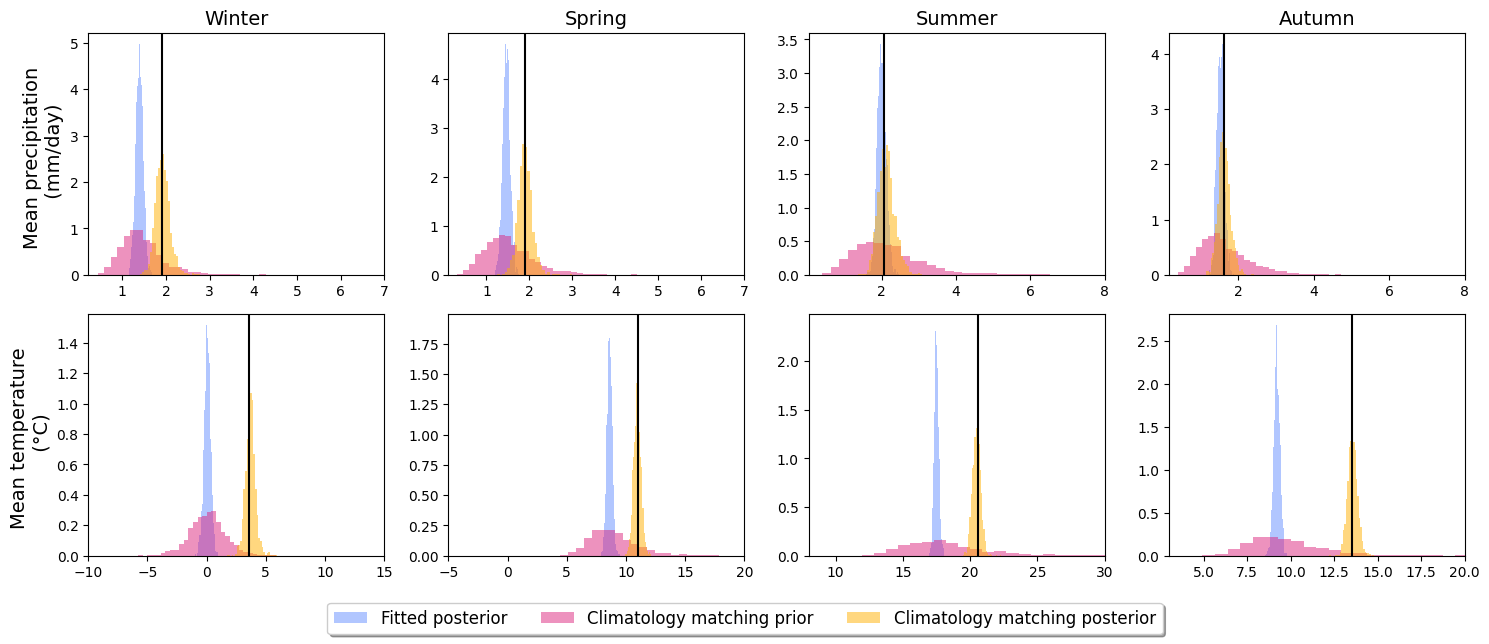

In [19]:
# Plot
idxs = [0, 1, 2, 3, 4, 5, 6, 7]

left_xlims = [None, None, None, None, -10, -5, 8, 3]
right_xlims = [7, 7, 8, 8, 15, 20, 30, 20]

samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = result.simulations["calibration_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = result.simulations["sbi_prior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = result.simulations["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target[jnp.array(idxs)]

# Color palette
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation \n (mm/day)", fontsize = 14)
axs[1, 0].set_ylabel("Mean temperature \n (°C)", fontsize = 14)

axs = axs.ravel()
axs[0].set_title("Winter", fontsize = 14)
axs[1].set_title("Spring", fontsize = 14)
axs[2].set_title("Summer", fontsize = 14)
axs[3].set_title("Autumn", fontsize = 14)

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(
        samples_summary_stats_reduced_plot["fitted_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["calibration_posterior"], label="Fitted posterior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_proposal"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_prior"], label="Climatology matching prior"
    )
    axs[i].hist(
        samples_summary_stats_reduced_plot["sbi_posterior"][:, i],
        bins=30, density=True, alpha=0.5,
        color=colors["sbi_posterior"], label="Climatology matching posterior"
    )
    axs[i].axvline(obs_stats_target_reduced_plot[i].flatten(), color="black")
    axs[i].set_xlim(left=left_xlims[i], right=right_xlims[i])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    loc='upper center', bbox_to_anchor=(0.5, -0.0),
    fancybox=True, shadow=True, ncol=5, fontsize=12
)

plt.savefig("plots/analysis_v2/case_study_3d.png", dpi=300, bbox_inches='tight')

In [20]:
ts = result.simulate_ts('sbi_posterior', 'sbi_posterior_map', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)

obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior_map"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2423.44it/s]


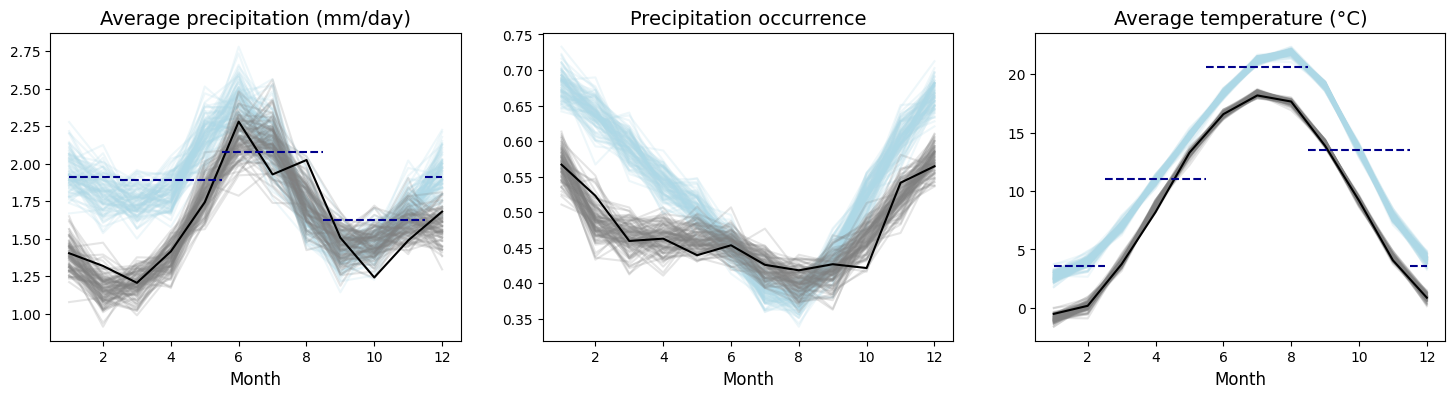

In [21]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3d_ensemble.png", dpi=300, bbox_inches='tight')

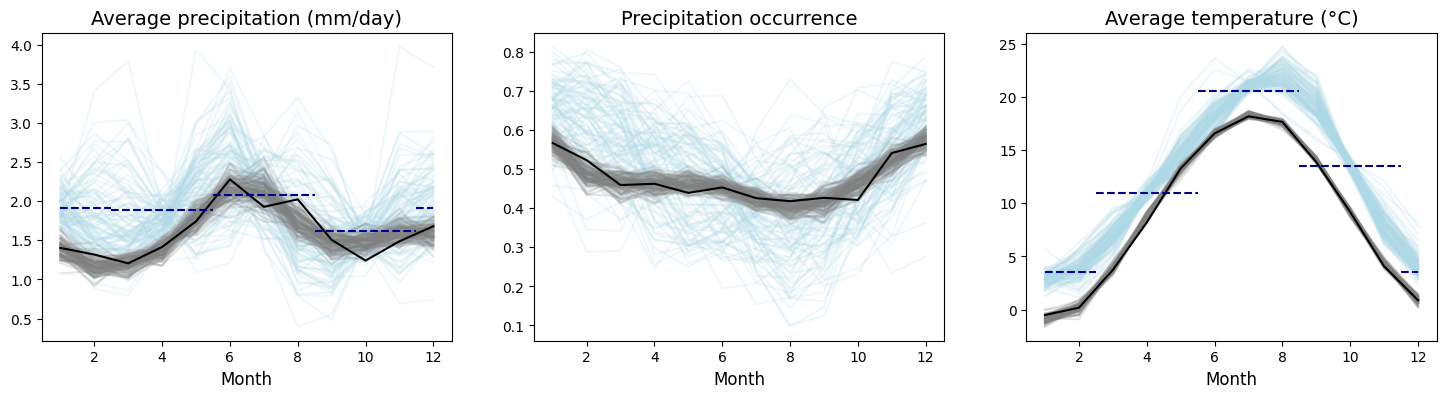

In [22]:
obs_hist = ts["calibration_posterior"]
obs_fut = ts["sbi_posterior"]

pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation (mm/day)", fontsize = 14)

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
axs[1].set_title("Precipitation occurrence", fontsize = 14)

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature (°C)", fontsize = 14)

axs[0].set_xlabel("Month", fontsize = 12)
axs[1].set_xlabel("Month", fontsize = 12)
axs[2].set_xlabel("Month", fontsize = 12)
axs[0].set_ylabel("")
axs[1].set_ylabel("")
axs[2].set_ylabel("")

plt.savefig("plots/analysis_v2/case_study_3d_ensemble_full_posterior.png", dpi=300, bbox_inches='tight')

### Comparison of Climatology matching posterior for occurrence

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2585.14it/s]


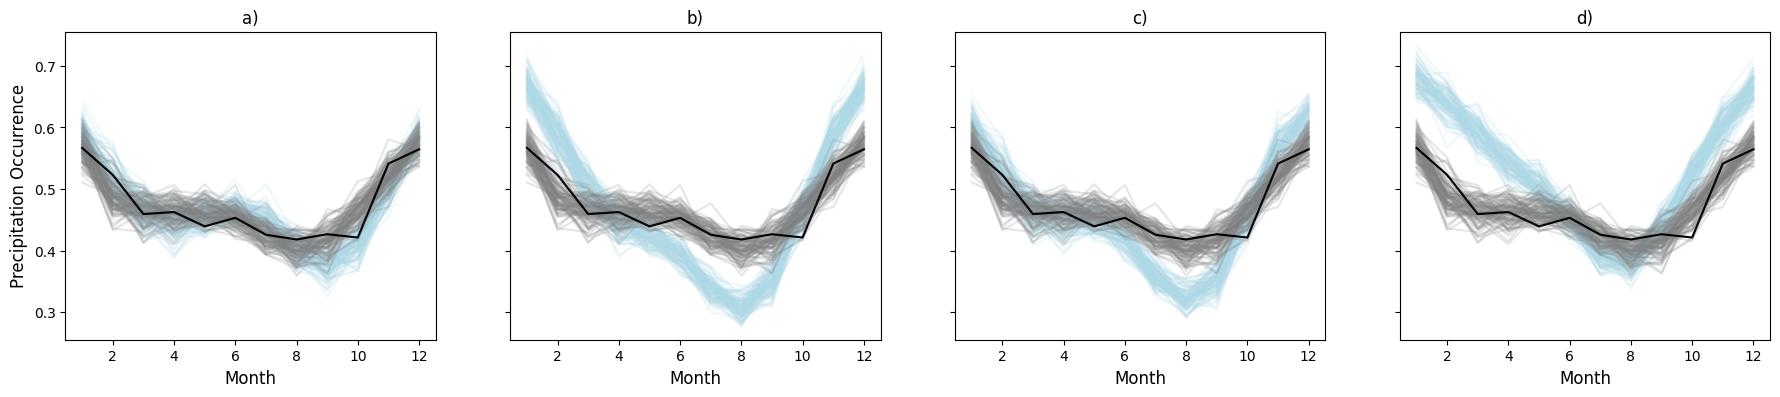

In [23]:
case_studies = ["3a", "3b", "3c", "3d"]
case_study_names = ["a)", "b)", "c)", "d)"]

fig, axs = plt.subplots(1,4, figsize = (22,4), sharey = True)

for i in range(4):

    case_study = case_studies[i]
    case_study_name = case_study_names[i]

    result = wxsbi.SBIResults.from_file(f"sbi_results/case_study_{case_study}.pkl")
    ts = result.simulate_ts('sbi_posterior_map', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)
    
    obs_hist = ts["calibration_posterior"]
    obs_fut = ts["sbi_posterior_map"]

    pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
    pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

    make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[i])
    axs[i].set_title(case_study_name)
    axs[i].set_xlabel("Month", fontsize = 12)

axs[0].set_ylabel("Precipitation Occurrence", fontsize = 12)


    #fig.suptitle("Precipitation occurrence")

plt.savefig("plots/analysis_v2/case_study_3_occ_comparison.png", dpi=300, bbox_inches='tight')

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 2518.00it/s]


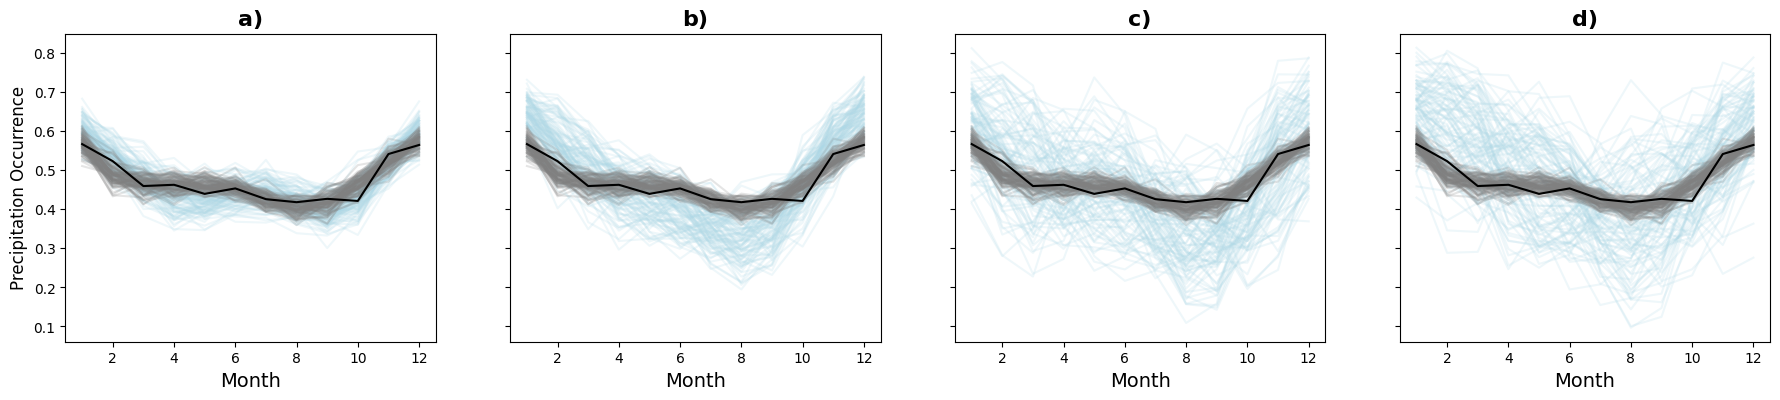

In [24]:
case_studies = ["3a", "3b", "3c", "3d"]
case_study_names = ["a)", "b)", "c)", "d)"]

fig, axs = plt.subplots(1,4, figsize = (22,4), sharey = True)

for i in range(4):

    case_study = case_studies[i]
    case_study_name = case_study_names[i]

    result = wxsbi.SBIResults.from_file(f"sbi_results/case_study_{case_study}.pkl")
    ts = result.simulate_ts('sbi_posterior', 'calibration_posterior', num_samples = 100, from_parameter_samples = False)
    
    obs_hist = ts["calibration_posterior"]
    obs_fut = ts["sbi_posterior"]

    pr_hist, tavg_hist = obs_hist['prec'][:, :, 0], obs_hist['Tavg'][:, :, 0]
    pr_fut, tavg_fut = obs_fut['prec'][:, :, 0], obs_fut['Tavg'][:, :, 0]

    make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[i])
    axs[i].set_title(case_study_name, fontsize=16, fontweight="bold")
    axs[i].set_xlabel("Month", fontsize = 14)
axs[0].set_ylabel("Precipitation Occurrence", fontsize = 12)

    #fig.suptitle("Precipitation occurrence")

plt.savefig("plots/analysis_v2/case_study_3_occ_comparison_full_posterior.png", dpi=300, bbox_inches='tight')